In [150]:
# Initialize Otter
import otter
grader = otter.Notebook("Traffic.ipynb")

# Final Project: Traffic
## Due Date: Monday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own groups**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

# Data 100 Final Project: Traffic in a post-lockdown world

**Scenario:** You're a data scientist at Uber -- sitting in a war room on March 16, 2020, 1 day after California-wide COVID lockdown measures began and the day shelter-in-place measures are announced in the bay area. The entire data science department is on fire: All of your existing traffic models have regressed *significantly*. Given the sudden change in traffic patterns (i.e., no traffic at all), the company's traffic estimates are wildly incorrect. This is a top priority for the company. Since traffic estimates are used directly for pricing strategies, this is actively costing the company millions every hour. You are tasked with fixing these models.

**Takeaways:** How do you "fix" models that have learned biases from pre-lockdown traffic? How do you train new ones, with just 24 hours of data? What sorts of data do you examine, to better understand the situation? In the midst of company-wide panic, you'll need a strong inferential acumen to lead a robust data science response. In this project, we'll walk you through a simulated war room data science effort, culminating in some strategies to fix models online, which are experiencing large distributional shifts in data.

For this project, we'll explore traffic data provided by the **Uber Movement** dataset, specifically around the start of COVID shutdowns in March 2020. Your project is structured around the following ideas:

```
1. Guided data cleaning: Clustering data spatially
    a. Load Uber traffic speeds dataset
    b. Map traffic speeds to Google Plus Codes (spatially uniform)
        i. Load node-to-gps-coordinates data
        ii. Map traffic speed to GPS coordinates
        iii. Convert GPS coordinates to plus code regions
        iv. Sanity check number of plus code regions in San Francisco
        v. Plot a histogram of the standard deviation in speed, per plus code region.
    c. Map traffic speeds to census tracts (spatially non-uniform)
        i. Download census tracts geojson
        ii. Map traffic speed to census tracts
        iii. Sanity check number of census tracts in San Francisco with data.
        iv. Plot a histogram of the standard deviation in speed, per census tract.
    d. What defines a "good" or "bad" spatial clustering?
2. Guided EDA: Understanding COVID lockdown impact on traffic
    a. How did lockdown affect average traffic speeds?
        i. Sort census tracts by average speed, pre-lockdown.
        ii. Sort census tracts by average speed, post-lockdown.
        iii. Sort census tracts by change in average speed, from pre to post lockdown.
        iv. Quantify the impact of lockdown on average speeds.
        v. Quantify the impact of pre-lockdown average speed on change in speed.
    b. What traffic areas were impacted by lockdown?
        i. Visualize heatmap of average traffic speed per census tract, pre-lockdown.
        ii. Visualize change in average daily speeds pre vs. post lockdown.
        iii. Quantify the impact of lockdown on daily speeds, spatially.
3. Open-Ended EDA: Understanding lockdown impact on traffic times
    a. Download Uber Movement (Travel Times) dataset
4. Guided Modeling: Predict traffic speed post-lockdown
    a. Predict daily traffic speed on pre-lockdown data
        i. Assemble dataset to predict daily traffic speed.
        ii. Train and evaluate linear model on pre-lockdown data.
    b. Understand failures on post-lockdown data
        i. Evaluate on post-lockdown data
        ii. Report model performance temporally
    c. "Fix" model on post-lockdown data
        i. Learn delta off of a moving bias
        ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?
        iii. Naively retrain model with post-lockdown data
        iv. What if you just ignore the change point?
5. Open-Ended Modeling: Predicting travel times post-lockdown
```

Concepts tested: regex, pivot, join, grouping, inferential thinking

In [151]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
from typing import Callable

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.
The iwut extension is already loaded. To reload it, use:
  %reload_ext iwut


# Step 1 - Guided Data Cleaning: Partitioning Data Spatially

Our hope is answer: How do we group information spatially? We'll specifically look at 2 ways of partitioning data spatially, to understand the impact of spatial partitioning strategies on our analyses:

1. Dividing the world uniformly into slices, like Google's plus codes.
2. Dividing the world according to population, using census tracts.

In this step, we'll load the following datasets that we'll need for this project:

- Daily travel times from Uber Movement data in March 2020 from San Francisco, by census tract
- Daily traffic speeds from Uber Movement data in Q1 2020 from San Francisco, between OSM nodes
- Census tracts dividing San Francisco by GPS coordinates
- Mapping from OSM nodes to GPS coordinates

There are several terms and concepts to get familiar with upfront:

- **Open Street Maps (OSM)** provides nodes (points in space, [wiki](https://wiki.openstreetmap.org/wiki/Node)) and ways (segments between nodes [wiki](https://wiki.openstreetmap.org/wiki/Way)). These IDs are used in the Uber Movement dataset to identify streets in the traffic speeds dataset.
- **Census Tracts** provided by the county of San Francisco geographically divides space according to the US 2010 Census. This is used in the Uber Movement dataset to identify regions of differing travel times.

## 1.a. Load Uber traffic speeds dataset

The dataset is located at `data/movement-speeds-daily-san-francisco-2020-3.csv`. **Load this dataset into a dataframe.**

*The original dataset from Uber was provided hourly and took up 2.1 GB on disk, which means it couldn't fit into your 1GB of RAM. You can find the dataset preparation script at `data/PrepareTrafficDataset.ipynb` which aggregated within each day, reducing the dataset to just 55MB on disk.*

*This was originally going to be question in this project, but it takes 22 minutes to run. Better yet, if you mess up, your kernel dies and you start over. We deemed it too frustrating and preprocessed the dataset to spare you the pain... but just know that this is a real-world issue!*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [152]:
# Load Uber Movement (Movement Speeds) dataset into dataframe
speeds_to_nodes = pd.read_csv('data/movement-speeds-daily-san-francisco-2020-3.csv')

speeds_to_nodes
speeds_to_nodes_prelockdown = speeds_to_nodes[speeds_to_nodes["day"] <= 13]
speeds_to_nodes_postlockdown = speeds_to_nodes[speeds_to_nodes["day"] > 13]
print(speeds_to_nodes_prelockdown.groupby(["day"]).count())
print(speeds_to_nodes_prelockdown.groupby(["day"]).count())
print(speeds_to_nodes_postlockdown.groupby(["day"]).mean())
print(speeds_to_nodes_postlockdown.groupby(["day"]).std())

     osm_start_node_id  osm_end_node_id  speed_mph_mean
day                                                    
1                78021            78021           78021
2               102479           102479          102479
3               107766           107766          107766
4               107528           107528          107528
5               107196           107196          107196
6               113605           113605          113605
7               100489           100489          100489
8                74473            74473           74473
9                86607            86607           86607
10               87114            87114           87114
11               82765            82765           82765
12               81017            81017           81017
13               84389            84389           84389
     osm_start_node_id  osm_end_node_id  speed_mph_mean
day                                                    
1                78021            78021         

In [153]:
grader.check("q1a")

q1a results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.b. Map traffic speed to Google Plus Codes

Google Plus Codes divide up the world uniformly into rectangular slices ([link](https://maps.google.com/pluscodes/)). Let's use this to segment traffic speeds spatially. Take a moment to answer: **Is this spatial structure effective for summarizing traffic speed?** Before completing this section, substantiate your answer with examples of your expectations (e.g., we expect A to be separated from B). After completing this section, substantiate your answer with observations you've made.

<!--
BEGIN QUESTION
name: q1b
points: 2
manual: True
-->

* Intuitively, the spatial structure divided by Google Plus Codes should be effective to summarize traffic speed. Given that the traffic speeds should be relatively close to each other in the same plus_code_region while the speeds in different plus_code_region are supposed to be different, the Google Plus Code should give a good division of geographically regions.

* After completing this section, we now go back to our prediction here and explain how our prediction makes sense. The differences between subpopulations (denoted by average_variance_by_pluscode=8.684748294968637 below) DO NOT outweight the differences within a subpopulation (denoted by variance_average_by_pluscode=10.136 below). However, as can be seen from histogram, most of the within subpopulation differences are quite small (<8mph). Thus, The differences between subpopulations should technically outweight the differences within a subpopulation. The smaller in-subpopulation differences and larger across-subpopulation differences make sense because the traffic speeds should be relatively close to each other in the same plus_code_region while the speeds in different plus_code_region are supposed to be different._Type your answer here, replacing this text._

<!-- END QUESTION -->



### 1.b.i. Load Node-to-GPS-Coordinate Data

In this substep, we'll load a mapping from OSM nodes to GPS coordinates. The dataset is provided in a gzip'ed XML file from OpenStreetMaps (OSM). The mapping from OSM nodes to GPS coordinates was downloaded from https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz. We've downloaded this for you, to avoid any issues with OSM updates.

**If** you try to load the provided `.osm` (an `.xml` in disguise) using Python's built-in XML utilities **(by uncommenting the last 2 lines in the below cell)**, you will hit an out-of-memory error, as your kernel is forced to restart.

In [154]:
# [OSM] - Read the OSM XML and extract mapping from node ID to GPS coordinates
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

# Runs out of memory! File itself is 430 MB, even when filtering out
# irrelevant rows, and remaining 3M rows are too expensive to parse,
# resulting in OOM

# import xml.etree.ElementTree as ET
# _tree = ET.parse(PATH_OSM)

Your above code hits a memory error, so instead, we will use our handy-dandy tool--regex--from earlier in the semester to load just the parts of the file that we need. **Given the XML snippet below, write a regex pattern to extract OSM node ID, latitude, and longitude.** (The first capture group should be node ID. The second should be latitude, and the third should be longitude.) A snippet of the XML is included below ([screenshot](https://extract.bbbike.org/extract-screenshots.html)):

```
<?xml version='1.0' encoding='UTF-8'?>
<osm version="0.6" generator="osmconvert 0.8.3">
    <bounds minlat="42.4543" minlon="-2.4761999" maxlat="42.4..."/>
    <node id="26861066" lat="42.471111" lon="-2.454722" version="..."/>
        <tag k="name" v="Camping La Playa"/>
        <tag k="tourism" v="camp_site"/>
        <tag k="operator" v="private"/>
        ...
    </node>
    <node id="34793287" lat="42.4713587" lon="-2.4510783" version="..."/>
        <tag k="created_by" v="JOSM"/>
    </node>
    <node id="34793294" lat="42.4610836" lon="-2.4303622" version="..."/>
    <node id="34793297" lat="42.4548363" lon="-2.4287657" version="..."/>
    ...
</osm>
```

In [155]:
# [OSM] - Read the OSM XML using a regex operation instead.
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    """
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    """
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [156]:
node_ids = set(speeds_to_nodes.osm_start_node_id) | set(speeds_to_nodes.osm_end_node_id)

NODE_PATTERN = r'id="(\d+)"\slat="([-]?\d+.\d*)"\slon="([-]?\d+.\d*)"'

node_to_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM,
    pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_to_gps

,osm_node_id,Latitude,Longitude
0,26118026,37.675280,-122.389194
1,29891973,37.674935,-122.389130
2,29892598,37.716892,-122.398893
3,30033679,37.599877,-122.376497
4,30033686,37.642167,-122.405946
...,...,...,...
19139,6522255428,37.760543,-122.443563
19140,6522255492,37.759317,-122.444996
19141,6522764204,37.762163,-122.436143
19142,6522764212,37.756061,-122.436761


In [157]:
grader.check("q1bi")

q1bi results: All test cases passed!

### 1.b.ii. Map traffic speed to GPS coordinates.

Traffic speeds are currently connected to OSM nodes. You will then use the mapping from OSM nodes to GPS coordinates, to map traffic speeds to GPS coordinates. **Link each traffic speed measurement to the GPS coordinate of its starting node.**

**Note**: For simplicity, assume each segment is associated with the node it *starts* with. 

**Hint**: Not all nodes are included in the OSM node mapping. Make sure to ignore any nodes without valid GPS coordinates.

<!--
BEGIN QUESTION
name: q1bii
points: 3
-->

In [158]:
# Find mapping from traffic speeds to GPS coordinates
speeds_to_gps = speeds_to_nodes.join(node_to_gps.set_index("osm_node_id"), on='osm_start_node_id', how = "inner")
speeds_to_gps
# speeds_to_nodes

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,Latitude,Longitude
141,26118026,259458979,1,64.478000,37.675280,-122.389194
78177,26118026,259458979,2,62.868208,37.675280,-122.389194
180660,26118026,259458979,3,62.211750,37.675280,-122.389194
288425,26118026,259458979,4,62.192458,37.675280,-122.389194
395950,26118026,259458979,5,61.913292,37.675280,-122.389194
...,...,...,...,...,...,...
1572913,4069109544,615120176,30,38.956000,37.732039,-122.507126
1374185,5448539901,65446993,16,25.627000,37.622476,-122.413763
1424401,302964668,4069109544,19,40.802000,37.732418,-122.507206
1441768,302964668,4069109544,20,36.076000,37.732418,-122.507206


In [159]:
grader.check("q1bii")

q1bii results: All test cases passed!

### 1.b.iii. Convert GPS coordinates to plus code regions.

Plus code regions divide up the world into uniformly-sized rectangles, which we will assume is 0.012 degrees latitudiunally and longitudinally. **For each traffic speed row, compute the plus code region it belongs to**, based on its GPS coordinates.

To do this, we suggest computing a latitudinal index `plus_latitude_idx` and a longitudinal index `plus_longitude_idx` for the plus code region each row belongs to. *Make sure these columns are integer-valued*.

**Hint**: If you're running into nans, you did 1.b.ii. incorrectly!

<!--
BEGIN QUESTION
name: q1biii
points: 3
-->

In [160]:
speeds_to_gps["plus_latitude_idx"] = (speeds_to_gps["Latitude"] // 0.012).map(lambda x: int(x)) # do this however you like
speeds_to_gps["plus_longitude_idx"] = (speeds_to_gps["Longitude"] // 0.012).map(lambda x: int(x))

speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
141,26118026,259458979,1,64.478000,37.675280,-122.389194,3139,-10200
78177,26118026,259458979,2,62.868208,37.675280,-122.389194,3139,-10200
180660,26118026,259458979,3,62.211750,37.675280,-122.389194,3139,-10200
288425,26118026,259458979,4,62.192458,37.675280,-122.389194,3139,-10200
395950,26118026,259458979,5,61.913292,37.675280,-122.389194,3139,-10200
...,...,...,...,...,...,...,...,...
1572913,4069109544,615120176,30,38.956000,37.732039,-122.507126,3144,-10209
1374185,5448539901,65446993,16,25.627000,37.622476,-122.413763,3135,-10202
1424401,302964668,4069109544,19,40.802000,37.732418,-122.507206,3144,-10209
1441768,302964668,4069109544,20,36.076000,37.732418,-122.507206,3144,-10209


In [161]:
grader.check("q1biii")

q1biii results: All test cases passed!

### 1.b.iv. Sanity check number of plus code regions in San Francisco.

**Compute the number of unique plus codes found in your dataset**. You're checking that the number isn't ridiculous, like 1, or 100,000 (SF is 231 sq mi, so 100k tracts would average 12 sq ft per tract).

If you followed the suggestion above, this is the number of unique `(plus_latitude_idx, plus_longitude_idx)` pairs.

<!--
BEGIN QUESTION
name: q1biv
points: 4
-->

In [162]:
# You're expecting 276 plus codes here. Don't just type "276" 
# below to pass the autograder. The goal is to sanity check your 
# dataframe!
unique_tuples = speeds_to_gps["plus_latitude_idx"] * 100000000 + speeds_to_gps["plus_longitude_idx"]
num_pluscode_regions = len(unique_tuples.unique())
num_pluscode_regions

276

In [163]:
grader.check("q1biv")

q1biv results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.b.v. How well do plus code regions summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "plus code region" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use the statistics above to answer these questions, and compute any additional statistics you need. Additionally explain *why these questions are important to assessing the quality of a spatial clustering*.

**Hint**: Run the autograder first to ensure your variance average and average variance are correct, before starting to draw conclusions.

In the first cell, write your written answers. In the second cell, complete the code.

<!--
BEGIN QUESTION
name: q1bv1
points: 2
manual: True
-->



* The average variance is overall reasonable.
* Firstly, the histogram of speed_variance_by_pluscode is skewed to the right and has a mode of around 5-7. As most of the small average speed variances are generally small (<10 mph), this small variance is reasonable and aligned with our real life as the traffic would of the similar speed in the same geographical region.
* While there are several relatively large speed variance above 15 mph, this large variance could be explained by the speedup and slow-down of traffic when the traffic light turns red or green. Thus, our experience with reality could easily explain the observations of speeds_to_gps in this right-skewed histogram.
* The differences between subpopulations (denoted by average_variance_by_pluscode=8.684748294968637 below) DO NOT outweight the differences within a subpopulation (denoted by variance_average_by_pluscode=10.136 below). However, as can be seen from histogram, most of the within subpopulation differences are quite small (<8mph). Thus, The differences between subpopulations should technically outweight the differences within a subpopulation. The smaller in-subpopulation differences and larger across-subpopulation differences make sense because the traffic speeds should be relatively close to each other in the same plus_code_region while the speeds in different plus_code_region are supposed to be different.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1bv2
points: 2
manual: True
-->

10.13573858675904

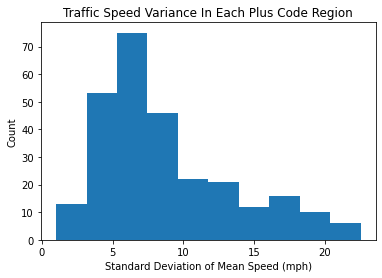

In [164]:
# compute traffic speed variance in each plus code region
speed_variance_by_pluscode = speeds_to_gps.groupby(["plus_latitude_idx", "plus_longitude_idx"]).std()["speed_mph_mean"] 
# plot a histogram
ax = speed_variance_by_pluscode.plot(kind='hist', title='Traffic Speed Variance In Each Plus Code Region') 
ax.set_xlabel("Standard Deviation of Mean Speed (mph)")
ax.set_ylabel("Count");
average_variance_by_pluscode = speed_variance_by_pluscode.mean()
variance_average_by_pluscode = (speeds_to_gps.groupby(["plus_latitude_idx", "plus_longitude_idx"]).mean()["speed_mph_mean"]).std()
variance_average_by_pluscode

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1bv3
points: 3
-->

In [165]:
speed_variance_by_pluscode

plus_latitude_idx  plus_longitude_idx
3128               -10210                 3.650232
                   -10198                20.704487
                   -10194                12.342234
3129               -10210                 4.083821
                   -10199                21.390912
                                           ...    
3160               -10198                15.293632
                   -10197                17.915911
                   -10196                14.243592
                   -10195                12.237229
                   -10194                17.590817
Name: speed_mph_mean, Length: 276, dtype: float64

In [166]:
grader.check("q1bv3")

q1bv3 results: All test cases passed!

## 1.c. Map traffic speed to census tract.

Census tracts divide the space much less uniformly, subdividing regions that we were interested in into smaller zones. This suggests promise in providing informative spatial segments. Note that the daily traffic speeds are provided between OpenStreetMap (OSM) nodes, so we'll need to map nodes to census tracts somehow.

Above, we've mapped traffic speeds to GPS coordinates. Below, we'll then link GPS coordinates to census tracts, to complete the mapping from traffic speeds to census tracts.

### 1.c.i. Download Census Tracts Geojson

**Load the census tracts geojson.** Make sure to see the relevant [geopandas io documentation](https://geopandas.org/docs/user_guide/io.html) to see how to load a geojson.

**Hint**: It should take you just one line to load.

<!--
BEGIN QUESTION
name: q1ci
points: 1
-->

In [167]:
import geopandas as gpd
PATH_TRACTS = os.path.expanduser('data/san_francisco_censustracts.json')
tract_to_gps = gpd.read_file(PATH_TRACTS)
tract_to_gps['MOVEMENT_ID'] = tract_to_gps['MOVEMENT_ID'].astype(int)
tract_to_gps

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"Sargent Creek, San Ardo","MULTIPOLYGON (((-121.59511 36.11126, -121.5401..."
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...","MULTIPOLYGON (((-122.22463 37.46507, -122.2236..."
2,3,"18300 Sutter Boulevard, Morgan Hill","MULTIPOLYGON (((-121.67978 37.15859, -121.6719..."
3,4,"2700 Stoughton Way, Sheffield, Sacramento","MULTIPOLYGON (((-121.35921 38.57175, -121.3462..."
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento","MULTIPOLYGON (((-121.37512 38.55309, -121.3715..."
...,...,...,...
2705,2706,"10000 Bobbell Drive, Elk Grove","MULTIPOLYGON (((-121.48392 38.40874, -121.4787..."
2706,2707,"400 Ericwood Court, Manteca","MULTIPOLYGON (((-121.22695 37.82647, -121.2185..."
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506..."
2708,2709,"1200 Halyard Drive, West Sacramento","MULTIPOLYGON (((-121.58346 38.57860, -121.5827..."


In [168]:
grader.check("q1ci")

q1ci results: All test cases passed!

### 1.c.ii Map traffic speed to census tracts.

You will need to *spatially join* the (1) mapping from traffic speed to GPS coordinates `speed_to_gps` and (2) the mapping from GPS coordinates to boundaries of census tracts `tract_to_gps` to group all traffic speeds by census tract. This "spatial join" is an advanced feature recently released (as of time of writing, in Oct 2021) in geopandas, which allows us to connect single points to their enclosing polygons. You will do this question in 3 parts:

1. Convert the last dataframe `speeds_to_gps` into a geopandas dataframe `speeds_to_points`, where GPS coordinates are now geopandas points. See this tutorial: https://geopandas.org/gallery/create_geopandas_from_pandas.html#From-longitudes-and-latitudes
2. Set the coordinate-system for the new geopandas dataframe to the "world geodesic system" [link](https://epsg.io/4326), or in other words, the coordinate system that GPS coordinates are reported in.
3. Compute a spatial join between census tracts `tract_to_gps` and the geopandas traffic speeds `speeds_to_points`

<!--
BEGIN QUESTION
name: q1cii
points: 4
-->

In [169]:
speeds_to_points = gpd.GeoDataFrame(
    speeds_to_gps, geometry=gpd.points_from_xy(speeds_to_gps.Longitude, speeds_to_gps.Latitude)).set_crs("EPSG:4326")
speeds_to_tract = speeds_to_points.sjoin(tract_to_gps, how='inner')

speeds_to_tract

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx,geometry,index_right,MOVEMENT_ID,DISPLAY_NAME
141,26118026,259458979,1,64.478000,37.675280,-122.389194,3139,-10200,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
78177,26118026,259458979,2,62.868208,37.675280,-122.389194,3139,-10200,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
180660,26118026,259458979,3,62.211750,37.675280,-122.389194,3139,-10200,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
288425,26118026,259458979,4,62.192458,37.675280,-122.389194,3139,-10200,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
395950,26118026,259458979,5,61.913292,37.675280,-122.389194,3139,-10200,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
...,...,...,...,...,...,...,...,...,...,...,...,...
539049,110424354,110424978,6,12.834000,37.896700,-122.539525,3158,-10212,POINT (-122.53952 37.89670),498,499,"600 Throckmorton Avenue, Mill Valley"
649438,110424354,110424978,7,15.586000,37.896700,-122.539525,3158,-10212,POINT (-122.53952 37.89670),498,499,"600 Throckmorton Avenue, Mill Valley"
904462,110424354,110424978,10,13.255000,37.896700,-122.539525,3158,-10212,POINT (-122.53952 37.89670),498,499,"600 Throckmorton Avenue, Mill Valley"
649059,110383033,110424972,7,19.423000,37.898306,-122.539984,3158,-10212,POINT (-122.53998 37.89831),498,499,"600 Throckmorton Avenue, Mill Valley"


In [170]:
grader.check("q1cii")

q1cii results: All test cases passed!

### 1.c.iii. Aggregate movement speeds by census tract.

- Create a new dataframe `speeds_by_tract` to group movement speeds by census tract. See the outputted dataframe from 1.c.i. to check how census tracts are identified.
- Always double-check your numbers. **Report the number of census tracts** in your dataset.

<!--
BEGIN QUESTION
name: q1ciii
points: 2
-->

In [171]:
speeds_by_tract = speeds_to_tract.groupby("MOVEMENT_ID").mean()
num_census_tracts = len(speeds_by_tract)
# speeds_by_tract
num_census_tracts

295

In [172]:
grader.check("q1ciii")

q1ciii results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.c.iv. How well do census tracts summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "census tract" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use these ideas to assess whether the average standard deviation is high or not.

Note: We are using the speed metric of miles per hour here.

Just like before, please written answers in the first cell and coding answers in the second cell.
<!--5. Using the above, how would you **compare census tracts to plus codes, in terms of its effectiveness** as a spatial clustering mechanism for analyzing traffic speeds? Compare the statistics you've computed. What does it mean for one to be higher than the other?-->

<!--
BEGIN QUESTION
name: q1civ1
points: 2
manual: True
-->



* The average variance is overall reasonable.
* Firstly, the histogram of speed_variance_by_pluscode is skewed to the right and has a mode of around 5-7. As most of the small average speed variances are generally small (<6 mph), this small variance is reasonable and aligned with our real life as the traffic would of the similar speed in the same geographical region.
* While there are several relatively large speed variance above 8 mph, this large variance could be explained by the speedup and slow-down of traffic when the traffic light turns red or green. Thus, our experience with reality could easily explain the observations of speeds_to_gps in this right-skewed histogram.
* The differences between subpopulations (denoted by average_variance_by_tract=8.300873802949297 below) DO NOT outweight the differences within a subpopulation (denoted by variance_average_by_tract=8.331964618884232 below). However, as can be seen from histogram, most of the within subpopulation differences are quite small (<6mph). Thus, The differences between subpopulations should technically outweight the differences within a subpopulation. The smaller in-subpopulation differences and larger across-subpopulation differences make sense because the traffic speeds should be relatively close to each other in the same plus_code_region while the speeds in different plus_code_region are supposed to be different.
* Compared to the Google Plus Code Regions, this method of grouping by census tract makes more sense because the differences within subpopulations are smalled to show the concentration of similar traffic speed in the same region.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1civ2
points: 2
manual: True
-->

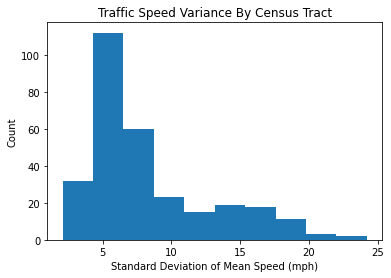

In [173]:
speed_variance_by_tract = speeds_to_tract.groupby("MOVEMENT_ID").std()["speed_mph_mean"]
ax = speed_variance_by_tract.plot(kind='hist', title='Traffic Speed Variance By Census Tract')
ax.set_xlabel("Standard Deviation of Mean Speed (mph)")
ax.set_ylabel("Count");
average_variance_by_tract = np.mean(speed_variance_by_tract)
variance_average_by_tract = np.std(speeds_to_tract.groupby(["MOVEMENT_ID"]).mean()["speed_mph_mean"])

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1civ3
points: 3
-->

In [174]:
speed_variance_by_tract

MOVEMENT_ID
9        3.821144
20       5.522853
21       3.640453
44       6.634154
78       3.838873
          ...    
2691     3.379664
2694     5.787065
2695     4.617596
2700    13.191079
2708     7.136608
Name: speed_mph_mean, Length: 295, dtype: float64

In [175]:
grader.check("q1civ3")

q1civ3 results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.d. What would be the ideal spatial clustering?

This is an active research problem in many spatiotemporal modeling communities, and there is no single agreed-upon answer. Answer both of the following specifically knowing that you'll need to analyze traffic patterns according to this spatial clustering:

1. **What is a good metric for a spatial structure?** How do we define good? Bad? What information do we expect a spatial structure to yield? Use the above parts and questions to help answer this.
2. **What would you do to optimize your own metric for success in a spatial structure?**

See related articles:

- Uber's H3 [link](https://eng.uber.com/h3/), which divides the world into hexagons
- Traffic Analysis Zones (TAZ) [link](https://en.wikipedia.org/wiki/Traffic_analysis_zone), which takes census data and additionally accounts for vehicles per household when dividing space

<!--
BEGIN QUESTION
name: q1d
points: 3
manual: True
-->

* From our model, when we first used plus code region as spatial structure to mesure speed, the areas of each grid is relatively larger than using census tract as spatial structure. This will result in a larger variances of the average speed within each areas. Therefore, we can conclude that a good spatial structure needs to yield the average speed that closes to the true speed within the area and a good model should divide up the region to an extend where it is small enough to produce an accurate average speed but not too small to yield insufficient information.
* In summary, the ideal spatial structure should be able to cover greater extent of the area, and the variance within the clustering should be small.
* Uber's hexagonal hierarchical spatial index is a better spatial structure. the hexagons minimize the quantization error introduced when users move through a city. Hexagons also allow us to approximate radiuses easily.

<!-- END QUESTION -->



# Step 2 - Guided EDA: Understanding COVID Lockdown Impact on Traffic

In this step, we'll examine the impact of COVID on traffic. In particular, we'll study 3 different questions:

- How did lockdown affect traffic speed? What factors dictate how much lockdown affected traffic speed?
- What areas of traffic were most impacted by lockdown?

## 2.a. How did lockdown affect traffic speed?

<!-- BEGIN QUESTION -->

### 2.a.i. Sort census tracts by average speed, pre-lockdown.

Consider the pre-lockdown period to be March 1 - 13, before the first COVID-related restrictions (travel bans) were announced on March 14, 2020.

1. **Report a DataFrame which includes the *names* of the 10 census tracts with the lowest average speed**, along with the average speed for each tract.
2. **Report a DataFrame which includes the *names* of the 10 census tracts with the highest average speed**, along with the average speed for each tract.
2. Do these names match your expectations for low speed or high speed traffic pre-lockdown?  What relationships do you notice? (What do the low-speed areas have in common? The high-speed areas?) For this specific question, answer qualitatively. No need to quantify. **Hint**: Look up some of the names on a map, to understand where they are.
3. **Plot a histogram for all average speeds, pre-lockdown**.
4. You will notice a long tail distribution of high speed traffic. What do you think this corresponds to in San Francisco? Write down your hypothesis.

Hint: To start off, think about what joins may be useful to get the desired DataFrame.

<!--
BEGIN QUESTION
name: q2ai1
points: 3
manual: True
-->

* Yes, those names match with the expectations. Low speed areas are around San Fransico downtown where has large populations to slow down the speed. By contrast, high speed areas are either on high ways or in hills (such as Half Moon Bay). Since there are less populations within those areas, the speed will be high compared with downtown areas.
* The long tail distribution of high spped traffic might be corresponded to high ways within San Fransicso.

<!-- END QUESTION -->

Answer the following question:
<!--
BEGIN QUESTION
name: q2ai2
points: 3
-->

In [176]:
# compute the average speed per census tract (will use this later),
# BEFORE the shelter-in-place was announced on March 14, 2020.
# Autograder expects this to be a series
pre_lockdown = speeds_to_tract[speeds_to_tract['day'] < 14]
averages_pre = pre_lockdown.dissolve(by='MOVEMENT_ID', aggfunc='mean')['speed_mph_mean'].sort_values()

# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_pre_named = averages_pre.to_frame().merge(tract_to_gps, how = 'left', on = 'MOVEMENT_ID')

averages_pre_named

,MOVEMENT_ID,speed_mph_mean,DISPLAY_NAME,geometry
0,1691,12.417079,"200 O'Farrell Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41462 37.78558, -122.4129..."
1,2340,12.595120,"0 Mason Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41405 37.78279, -122.4107..."
2,1688,12.945291,"1100 Taylor Street, Nob Hill, San Francisco","MULTIPOLYGON (((-122.41629 37.79389, -122.4152..."
3,651,13.195865,"2900 22nd Street, Mission District, San Francisco","MULTIPOLYGON (((-122.41672 37.75717, -122.4123..."
4,643,13.490311,"200 Myrtle Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.42146 37.78663, -122.4182..."
...,...,...,...,...
290,1744,45.492292,"1200 Helen Drive, Millbrae","MULTIPOLYGON (((-122.42820 37.60497, -122.4263..."
291,2339,47.225137,"Frenchmans Creek Road, Half Moon Bay","MULTIPOLYGON (((-122.46816 37.56079, -122.4605..."
292,1653,47.318340,"Petrolite Street, Richmond","MULTIPOLYGON (((-122.42976 37.96540, -122.4185..."
293,495,53.867847,"4200 Shelter Creek Lane, San Bruno","MULTIPOLYGON (((-122.43101 37.61999, -122.4300..."


In [177]:
grader.check("q2ai2")

q2ai2 results: All test cases passed!

Report the lowest 10 census tracts with the lowest average speed
Remember we want the NAME of each census tract too. For the autograder, please keep the name of the speed field, `speed_mph_mean`.

<!--
BEGIN QUESTION
name: q2ai3
points: 1
-->

In [178]:
bottom10_averages_pre = averages_pre_named.sort_values(by = "speed_mph_mean").head(10)
bottom10_averages_pre

,MOVEMENT_ID,speed_mph_mean,DISPLAY_NAME,geometry
0,1691,12.417079,"200 O'Farrell Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41462 37.78558, -122.4129..."
1,2340,12.595120,"0 Mason Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41405 37.78279, -122.4107..."
2,1688,12.945291,"1100 Taylor Street, Nob Hill, San Francisco","MULTIPOLYGON (((-122.41629 37.79389, -122.4152..."
3,651,13.195865,"2900 22nd Street, Mission District, San Francisco","MULTIPOLYGON (((-122.41672 37.75717, -122.4123..."
4,643,13.490311,"200 Myrtle Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.42146 37.78663, -122.4182..."
5,1689,13.502505,"200 Sutter Street, Financial District, San Fra...","MULTIPOLYGON (((-122.40879 37.79016, -122.4071..."
6,1244,13.549474,"800 Jackson Street, Chinatown, San Francisco","MULTIPOLYGON (((-122.41172 37.79629, -122.4084..."
7,1245,13.570625,"500 Geary Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41500 37.78745, -122.4133..."
8,644,13.626251,"200 Jones Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41443 37.78466, -122.4127..."
9,1674,13.944773,"200 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41771 37.78424, -122.4160..."


In [179]:
grader.check("q2ai3")

q2ai3 results: All test cases passed!

Report the highest 10 census tracts with the highest average speed.

<!--
BEGIN QUESTION
name: q2ai4
points: 1
-->

In [180]:
top10_averages_pre = averages_pre_named.sort_values(by = "speed_mph_mean", ascending=False).head(10)
top10_averages_pre

,MOVEMENT_ID,speed_mph_mean,DISPLAY_NAME,geometry
294,285,59.498552,"1600 Maritime Street, Oakland","MULTIPOLYGON (((-122.33037 37.82058, -122.3161..."
293,495,53.867847,"4200 Shelter Creek Lane, San Bruno","MULTIPOLYGON (((-122.43101 37.61999, -122.4300..."
292,1653,47.318340,"Petrolite Street, Richmond","MULTIPOLYGON (((-122.42976 37.96540, -122.4185..."
291,2339,47.225137,"Frenchmans Creek Road, Half Moon Bay","MULTIPOLYGON (((-122.46816 37.56079, -122.4605..."
290,1744,45.492292,"1200 Helen Drive, Millbrae","MULTIPOLYGON (((-122.42820 37.60497, -122.4263..."
289,2244,44.304919,"0 Crystal Springs Terrace, Hillsborough Park, ...","MULTIPOLYGON (((-122.37189 37.54776, -122.3710..."
288,2660,43.848188,"0 Burgess Court, Sausalito","MULTIPOLYGON (((-122.52032 37.87046, -122.5193..."
287,1955,42.784267,"Liccicitos Road, Moss Beach","MULTIPOLYGON (((-122.52036 37.57534, -122.5180..."
286,1732,40.587037,"0 Longview Drive, Westlake, Daly City","MULTIPOLYGON (((-122.50053 37.70083, -122.4961..."
285,1743,38.944079,"600 San Bruno Avenue East, San Bruno","MULTIPOLYGON (((-122.41676 37.63935, -122.4115..."


In [181]:
grader.check("q2ai4")

q2ai4 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2ai5
points: 1
manual: True
-->

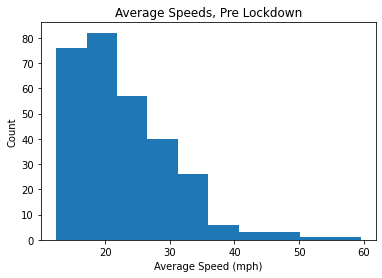

In [182]:
ax = averages_pre.plot(kind='hist', title='Average Speeds, Pre Lockdown')
ax.set_xlabel("Average Speed (mph)")
ax.set_ylabel("Count");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.ii. Sort census tracts by average speed, post-lockdown.

I suggest checking the top 10 and bottom 10 tracts by average speed, post-lockdown. Consider the post-lockdown period to be March 14 - 31, after the first COVID restrictions were established on March 14, 2020. It's a healthy sanity check. For this question, you should report:

- **Plot a histogram for all average speeds, post-lockdown.**
- **What are the major differences between this post-lockdown histogram relative to the pre-lockdown histogram above**? Anything surprising? What did you expect, and what did you find?

Write the written answers in the cell below, and the coding answers in the cells after that.

<!--
BEGIN QUESTION
name: q2aii1
points: 1
manual: True
-->

* The post-lockdown histogram has a lot higher average speed that the pre-lockdown histogram, and the post-lockdown histogram's maximal value (slightly above 70mph) is higher thatn the pre-lockdown histogram's maximal value (slightly below 60mph).
* Besides, the post-lockdown histogram has a lot higher speed variance that the pre-lockdown histogram simply due to higher traveling speed.
* This relative difference is not surprising but aligned with our expectation since there would be fewer vehicles during post-lockdown, thereby enabling vehicles to travel a lot faster.

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q2aii2
points: 2
-->

In [183]:
post = speeds_to_tract[speeds_to_tract['day'] >= 14]
averages_post = post.dissolve(by='MOVEMENT_ID', aggfunc='mean')['speed_mph_mean']

# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_post_named = averages_post.to_frame().merge(tract_to_gps, how = 'left', on = 'MOVEMENT_ID')

averages_post_named

,MOVEMENT_ID,speed_mph_mean,DISPLAY_NAME,geometry
0,9,16.143154,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150..."
1,20,16.871488,"900 Sutter Street, Lower Nob Hill, San Francisco","MULTIPOLYGON (((-122.42208 37.78847, -122.4153..."
2,21,15.754795,"3400 Pierce Street, Marina District, San Franc...","MULTIPOLYGON (((-122.44191 37.80374, -122.4371..."
3,44,25.956602,"1700 Egbert Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.40211 37.72779, -122.3998..."
4,78,16.476000,"1400 Thomas Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.39270 37.72928, -122.3918..."
...,...,...,...,...
280,2691,17.917000,"800 Hacienda Way, Millbrae","MULTIPOLYGON (((-122.42288 37.60714, -122.4187..."
281,2694,22.128519,"1900 Buchanan Street, Western Addition, San Fr...","MULTIPOLYGON (((-122.43549 37.78870, -122.4338..."
282,2695,23.440404,"2200 Rivera Street, Sunset District, San Franc...","MULTIPOLYGON (((-122.49505 37.74968, -122.4858..."
283,2700,38.807594,"300 Ponderosa Road, Avalon, South San Francisco","MULTIPOLYGON (((-122.44834 37.64598, -122.4460..."


In [184]:
grader.check("q2aii2")

q2aii2 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2aii3
points: 1
manual: True
-->

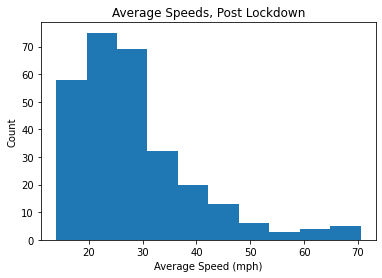

In [185]:
ax = averages_post.plot(kind='hist', title='Average Speeds, Post Lockdown')
ax.set_xlabel("Average Speed (mph)")
ax.set_ylabel("Count");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iii. Sort census tracts by change in traffic speed from pre to post lockdown.

For each segment, compute the difference between the pre-lockdown average speed (March 1 - 13) and the post-lockdown average speed (March 14 - 31). **Plot a histogram of all differences.** Sanity check that the below histogram matches your observations of the histograms above, on your own.

<!--
BEGIN QUESTION
name: q2aiii
points: 2
manual: True
-->

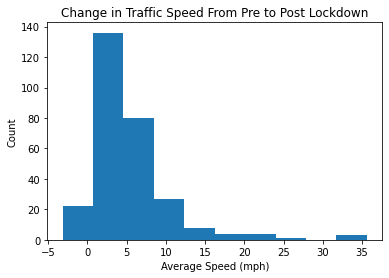

In [186]:
# The autograder expects differences to be a series object with index
# MOVEMENT_ID.
differences = averages_post - averages_pre
# plot the differences
ax = differences.plot(kind='hist', title='Change in Traffic Speed From Pre to Post Lockdown')
ax.set_xlabel("Average Speed (mph)")
ax.set_ylabel("Count");

In [187]:
grader.check("q2aiii")

q2aiii results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iv. Quantify the impact of lockdown on average speeds.

1. **Plot the average speed by day, across all segments**. Be careful not to plot the average of census tract averages instead. Recall the definition of segments from Q1.
2. Is the change in speed smooth and gradually increasing? Or increasing sharply? Why? Use your real-world knowledge of announcements and measures during that time, in your explanation. You can use this list of bay area COVID-related dataes: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/

<!--
BEGIN QUESTION
name: q2aiv1
points: 1
manual: True
-->

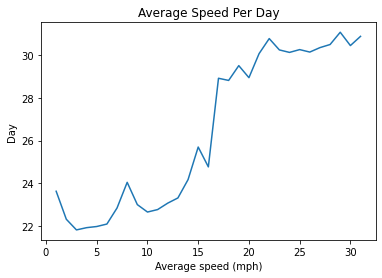

In [188]:
# Autograder expects this to be a series object containing the
# data for your line plot -- average speeds per day.
speeds_daily = speeds_to_tract.groupby("day").mean()["speed_mph_mean"]
plt.plot(speeds_daily)
plt.xlabel("Average speed (mph)")
plt.ylabel("Day")
plt.title("Average Speed Per Day");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Write your written answer in the cell below

<!--
BEGIN QUESTION
name: q2aiv2
points: 1
manual: True
-->

* The change in speed between pre and post lockdown increased sharply rather than smoothly. This might be caused by travel restricitons, bans of mass gatherings, and lockdowns in the city. As a result, less people go out and drive. With this decrease in traffic, people's average driving speed drastically increases.
* On March 11, 2020, SF bans public gatherings of 1, 000 people or more. Starting on this day, we can see the average speed increases gradually till March 15.
* On March 15, the Centers for Disease Control warns agains holding any gatherings larger than 50 people. With this strict restriction, the average speed further increases drastically.

<!-- END QUESTION -->

Ignore the empty cell below, just run the autograder to test the code above is correct.
<!--
BEGIN QUESTION
name: q2aiv3
points: 1
-->

In [189]:
grader.check("q2aiv3")

q2aiv3 results: All test cases passed!

<!-- BEGIN QUESTION -->

### 2.a.v. Quantify the impact of pre-lockdown average speed on change in speed.

1. Compute the correlation between change in speed and the *pre*-lockdown average speeds. Do we expect a positive or negative correlation, given our analysis above?
2. Compute the correlation between change in speed and the post-lockdown average speeds.
3. **How does the correlation in Q1 compare with the correlation in Q2?** You should expect a significant change in correlation value. What insight does this provide about traffic?

Written answers in the first cell, coding answerts in the following cell.

<!--
BEGIN QUESTION
name: q2av1
points: 2
manual: True
-->

* The correlation in Q1 (correlation between pre-lockdown traffic and difference) is siginicantly low than the correlation in Q2 (correlation between post-lockdown traffic and difference).
* There is a strong linear positive correlation between post-lockdown traffic and difference.
* The correlation between pre-lockdown traffic and difference doesn't mean anything, because the difference of traffic is not related to the pre-lockdown traffic. However, the post-lockdown traffic determined the difference, thus leading to a strong linear positive correlation between post-lockdown traffic and difference. Intuitively, this also makes sense because the higher post-lockdown traffic speed leads to higher difference traffic speeds.

<!-- END QUESTION -->


<!--
BEGIN QUESTION
name: q2av2
points: 2
-->

In [190]:
corr_pre_diff = pd.DataFrame(data={"averages_post":averages_pre,"difference":differences}).corr()["averages_post"]["difference"]
corr_pre_diff
corr_post_diff = pd.DataFrame(data={"averages_pre":averages_post,"difference":differences}).corr()["averages_pre"]["difference"]
corr_pre_diff, corr_post_diff

(0.4633006380580185, 0.7926799984780661)

In [191]:
grader.check("q2av2")

q2av2 results: All test cases passed!

## 2.b. What traffic areas were impacted by lockdown?

<!-- BEGIN QUESTION -->

### 2.b.i. Visualize spatial heatmap of average traffic speed per census tract, pre-lockdown.

Visualize a spatial heatmap of the grouped average daily speeds per census tract, which you computed in previous parts. Use the geopandas [chloropleth maps](https://geopandas.org/docs/user_guide/mapping.html#choropleth-maps). **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest**. These may be a local extrema, or a region that is strangely all similar.

**Hint**: Use [`to_crs`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) and make sure the `epsg` is using the Pseudo-Mercator projection.

**Hint**: You can use `contextily` to superimpose your chloropleth map on a real geographic map.

**Hint** You can set a lower opacity for your chloropleth map, to see what's underneath, but be aware that if you plot with too low of an opacity, the map underneath will perturb your chloropleth and meddle with your conclusions.

Written answers in the first cell, coding answers in the second cell.

<!--
BEGIN QUESTION
name: q2bi1
points: 1
manual: True
-->

* Areas around highways and the bridges have higher average speed since there's no condensed population.
* The yellow area is has the fastest average speed since there's the Middle Harbor Shoreline Park. Parks has limited number of visitors to cause traffic.
* The downtown purple area has the lowest average speeds since there's a lot of people there. There are lots of types of transportation in downtown, so traffic speed is not as fast like on highways.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bi2
points: 4
manual: True
-->

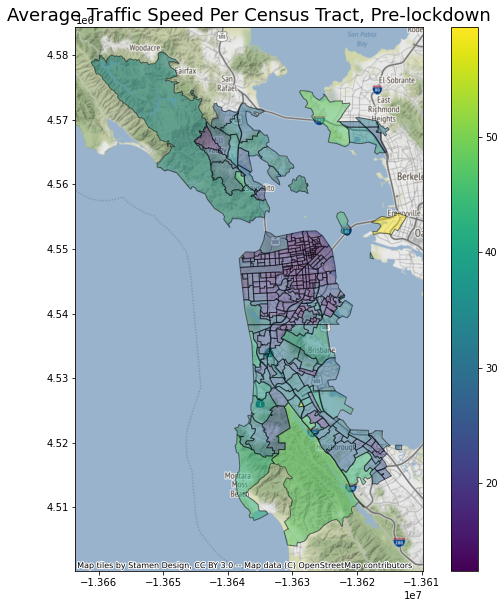

In [192]:
averages_pre_named_gdf = gpd.GeoDataFrame(averages_pre_named, geometry='geometry')
averages_pre_named_gdf = averages_pre_named_gdf.to_crs(epsg=3857)

ax = averages_pre_named_gdf.plot(figsize=(10, 10),  alpha = 0.5, edgecolor='k',  column = 'speed_mph_mean', legend = True)
ax.set_title("Average Traffic Speed Per Census Tract, Pre-lockdown", fontsize=18)
cx.add_basemap(ax);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.b.ii. Visualize change in average daily speeds pre vs. post lockdown.

Visualize a spatial heatmap of the census tract differences in average speeds, that we computed in a previous part. **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest.** Some possible ideas for interesting notes: Which areas saw the most change in average speed? Which areas weren't affected? Why did some areas see *reduced* average speed?

First cell is for the written answers, second cell is for the coding answers.

<!--
BEGIN QUESTION
name: q2bii1
points: 1
manual: True
-->

* Before the covid shutdown, people needs to drive to their workplace which causes San Jose, Mountain View areas to have slower traffic speed. After the shutdown, people will choose to work from home which decrease the traffic conjunction.
* Overall, the colors within the Bay area becomes light indicating the speed increases.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bii2
points: 4
manual: True
-->

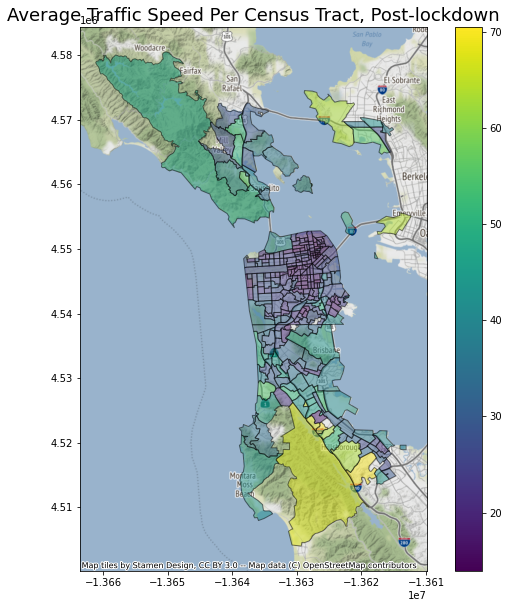

In [193]:
averages_post_named_gdf = gpd.GeoDataFrame(averages_post_named, geometry='geometry')
averages_post_named_gdf = averages_post_named_gdf.to_crs(epsg=3857)

ax = averages_post_named_gdf.plot(figsize=(10, 10),  alpha = 0.5, edgecolor='k',  column = 'speed_mph_mean', legend = True)
ax.set_title("Average Traffic Speed Per Census Tract, Post-lockdown", fontsize=18)
cx.add_basemap(ax);

<!-- END QUESTION -->



# Step 3 - Open-Ended EDA: Understanding lockdown impact on travel times

Explore daily travel times from Hayes Valley to other destinations both before and throughout lockdown. Use the following questions as suggestions for what to explore, temporally and spatially:

- How did lockdown affect travel times? Are there any meaningful factors that determined how travel time would be impacted? How was travel time affected over time?
- Travel to which destinations were affected by lockdown? Are there surprisingly disproportionate amounts of impact in certain areas?

## 3.a. Load Datasets

In this step, we will load two datasets:

- Daily travel times from Hayes Valley to all other census tracts around San Francisco.
- Daily travel times from 300 Hayes St to Golden Gate Park in San Francisco.

For this specific set of data, we can ask several more questions; which questions you pursue are up to you, including any that you come up that are not on this list:

- Which routes from Hayes Valley had similar impact on travel time? Did they share any factors in common? Traveling through the same place -- e.g., a freway? Traveling in similar areas e.g., residential areas?
- Were clusters of routes impacted more severely than others over time? What determined the degree of impact?

In [194]:
PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract = pd.read_csv(PATH_TIMES)
times_to_tract

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day
0,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",322,211,489,1
1,1277,"300 Hayes Street, Civic Center, San Francisco",20,"900 Sutter Street, Lower Nob Hill, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",291,179,470,1
2,1277,"300 Hayes Street, Civic Center, San Francisco",21,"3400 Pierce Street, Marina District, San Franc...","3/1/2020 - 3/1/2020, Every day, Daily Average",635,438,920,1
3,1277,"300 Hayes Street, Civic Center, San Francisco",44,"1700 Egbert Avenue, Bayview, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",786,566,1090,1
4,1277,"300 Hayes Street, Civic Center, San Francisco",46,"500 Chester Street, West Oakland, Oakland","3/1/2020 - 3/1/2020, Every day, Daily Average",891,682,1162,1
...,...,...,...,...,...,...,...,...,...
10333,1277,"300 Hayes Street, Civic Center, San Francisco",2624,"1300 16th Avenue, Inner Sunset, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",502,411,611,31
10334,1277,"300 Hayes Street, Civic Center, San Francisco",2643,"1300 Egbert Avenue, Bayview, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",571,475,685,31
10335,1277,"300 Hayes Street, Civic Center, San Francisco",2673,"100 Rutledge Street, Bernal Heights, San Franc...","3/31/2020 - 3/31/2020, Every day, Daily Average",367,265,507,31
10336,1277,"300 Hayes Street, Civic Center, San Francisco",2694,"1900 Buchanan Street, Western Addition, San Fr...","3/31/2020 - 3/31/2020, Every day, Daily Average",222,167,294,31


In [195]:
# PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
# times_to_tract = pd.read_csv(PATH_TIMES)
# times_to_tract

### uncomment the lines below to produce a graph (commented out for gradescope submission purpose

In [196]:
# times_to_tract.isnull().any()

### As Can be seen above, there are no null values in the data frame.

In [197]:
# print("All Possible Origin Movement ID: " + str(set(times_to_tract["Origin Movement ID"])))
# print("All Possible Origin Display Name: " + str(set(times_to_tract["Origin Display Name"])))
# print("The Number of Different Possible Destination Movement ID: " + str(len(set(times_to_tract["Destination Movement ID"]))))
# print("The Number of Different Possible Destination Display Name: " + str(len(set(times_to_tract["Destination Display Name"]))))
# print("All Possible days: " + str(set(times_to_tract["day"])))

### The granularity of the dataset is travel record on each route on a particular day in March 2020. All of the routes start from '300 Hayes Street, Civic Center, San Francisco' and end in 601 different possible destinations. We can use the travel time as grouped by different routes and different days/dates to analyze the change and periodicity of traffic between pre-lockdown and post-lockdown as varied by different time.

In [198]:
# times_to_tract_prelockdown = times_to_tract[times_to_tract['day'] < 14]
# times_to_tract_prelockdown

In [199]:
# times_to_tract_postlockdown = times_to_tract[times_to_tract['day'] >= 14]
# times_to_tract_postlockdown

In [200]:
# times_to_tract_prelockdown_gps = tract_to_gps.merge(times_to_tract_prelockdown, left_on="MOVEMENT_ID", right_on="Destination Movement ID", how = "inner")
# times_to_tract_prelockdown_gps

In [201]:
# pre_mean_travel_time = times_to_tract_prelockdown_gps.groupby("Destination Movement ID").mean().reset_index()[['Destination Movement ID', 'Mean Travel Time (Seconds)']].rename(columns={'Mean Travel Time (Seconds)':'Pre Mean Travel Time (Seconds)'})
# pre_mean_travel_time

In [202]:
# times_to_tract_postlockdown_gps = tract_to_gps.merge(times_to_tract_postlockdown, left_on="MOVEMENT_ID", right_on="Destination Movement ID", how = "inner")
# times_to_tract_postlockdown_gps

In [203]:
# post_mean_travel_time = times_to_tract_postlockdown_gps.groupby("Destination Movement ID").mean().reset_index()[['Destination Movement ID', 'Mean Travel Time (Seconds)']].rename(columns={'Mean Travel Time (Seconds)':'Post Mean Travel Time (Seconds)'})
# post_mean_travel_time

In [204]:
# times_to_tract_prelockdown_gps = tract_to_gps.merge(times_to_tract_prelockdown, left_on="MOVEMENT_ID", right_on="Destination Movement ID", how = "inner")
# times_to_tract_postlockdown_gps = tract_to_gps.merge(times_to_tract_postlockdown, left_on="MOVEMENT_ID", right_on="Destination Movement ID", how = "inner")
# times_to_tract_gps = tract_to_gps.merge(times_to_tract, left_on="MOVEMENT_ID", right_on="Destination Movement ID", how = "inner")
# times_to_tract_gps_groupby_movementID = times_to_tract_gps.groupby(['MOVEMENT_ID'])[["Destination Movement ID", "Mean Travel Time (Seconds)"]].mean()
# times_to_tract_gps_groupby_movementID_joined_with_day = times_to_tract_gps_groupby_movementID.merge(times_to_tract_gps, left_on="MOVEMENT_ID", right_on="MOVEMENT_ID", how="inner")
# times_to_tract_gps = times_to_tract_gps.merge(pre_mean_travel_time, how='inner', on='Destination Movement ID')
# times_to_tract_gps = times_to_tract_gps.merge(post_mean_travel_time, how='inner', on='Destination Movement ID')
# times_to_tract_gps['Mean Difference Travel Time (Seconds)'] = times_to_tract_gps['Pre Mean Travel Time (Seconds)'] - times_to_tract_gps['Post Mean Travel Time (Seconds)'] 
# # print(times_to_tract_gps["day"].unique())
# times_to_tract_gps

In [205]:
# ax = times_to_tract_gps[['Pre Mean Travel Time (Seconds)']].plot(kind='hist', title='Mean Travel Time Prelockdown (Seconds)', legend=False)
# ax.set_xlabel("Mean Travel Time (Seconds)")
# ax.set_ylabel("Count");

In [206]:
# ax = times_to_tract_gps[['Post Mean Travel Time (Seconds)']].plot(kind='hist', title='Mean Travel Time Postlockdown (Seconds)', legend=False)
# ax.set_xlabel("Mean Travel Time (Seconds)")
# ax.set_ylabel("Count");

In [207]:
# ax = times_to_tract_gps[['Mean Difference Travel Time (Seconds)']].plot(kind='hist', title='Mean Difference Travel Time (Seconds)', legend=False)
# ax.set_xlabel("Mean Travel Time (Seconds)")
# ax.set_ylabel("Count");

In [208]:
# pre = gpd.GeoDataFrame(times_to_tract_gps, geometry='geometry')
# pre = pre.to_crs(epsg=3857)

# ax = pre.plot(figsize=(10, 10),  alpha = 0.5, edgecolor='k', column = 'Pre Mean Travel Time (Seconds)', legend = True)
# ax.set_title("Average Travel Time Per Census Tract, Pre-lockdown", fontsize=18)
# cx.add_basemap(ax);

In [209]:
# post = gpd.GeoDataFrame(times_to_tract_gps, geometry='geometry')
# post = post.to_crs(epsg=3857)

# ax = post.plot(figsize=(10, 10),  alpha = 0.5, edgecolor='k', column = 'Post Mean Travel Time (Seconds)', legend = True)
# ax.set_title("Average Travel Time Per Census Tract, Post-lockdown", fontsize=18)
# cx.add_basemap(ax);

In [210]:
# diff = gpd.GeoDataFrame(times_to_tract_gps, geometry='geometry')
# diff = diff.to_crs(epsg=3857)

# ax = diff.plot(figsize=(10, 10),  alpha = 0.5, edgecolor='k', column = 'Mean Difference Travel Time (Seconds)', legend = True)
# ax.set_title("Average Travel Time Difference Per Census Tract", fontsize=18)
# cx.add_basemap(ax);

In [211]:
# times_to_tract_gps_weekday = times_to_tract_gps.copy()
# times_to_tract_gps_weekday["Day of The Week"] = (times_to_tract_gps_weekday["day"] - 1) % 7
# boolean_to_binary = {True: 1, False: 0}
# times_to_tract_gps_weekday["Weekend(1) or Weekday(0)"] = times_to_tract_gps_weekday["Day of The Week"].isin([0, 6]).apply(lambda bo: boolean_to_binary[bo])
# times_to_tract_gps_weekday.head()

In [212]:
# times_to_tract_gps_weekday_1 = times_to_tract_gps_weekday[times_to_tract_gps_weekday["Weekend(1) or Weekday(0)"] == 1]
# times_to_tract_gps_weekday_0 = times_to_tract_gps_weekday[times_to_tract_gps_weekday["Weekend(1) or Weekday(0)"] == 0]
# plt.hist(times_to_tract_gps_weekday_1[['Mean Travel Time (Seconds)']], alpha=1, label="Weekend")
# plt.hist(times_to_tract_gps_weekday_0[['Mean Travel Time (Seconds)']], alpha=0.2, label="Weekday")
# plt.legend()
# plt.title("Mean Travel Time On Weekdays and Weekends")
# plt.xlabel("Mean Travel Time (Seconds)")
# plt.ylabel("Count");

In [213]:
# times_to_tract_gps_weekday_1_pre = times_to_tract_gps_weekday_1[times_to_tract_gps_weekday_1['day'] < 14]
# times_to_tract_gps_weekday_0_pre = times_to_tract_gps_weekday_0[times_to_tract_gps_weekday_0['day'] < 14]
# plt.hist(times_to_tract_gps_weekday_1_pre[['Pre Mean Travel Time (Seconds)']], alpha=1, label="Weekend")
# plt.hist(times_to_tract_gps_weekday_0_pre[['Pre Mean Travel Time (Seconds)']], alpha=0.2, label="Weekday")
# plt.legend()
# plt.title("Mean Travel Time On Weekdays and Weekends, Pre-lockdown")
# plt.xlabel("Mean Travel Time (Seconds)")
# plt.ylabel("Count");

In [214]:
# times_to_tract_gps_weekday_1_post = times_to_tract_gps_weekday_1[times_to_tract_gps_weekday_1['day'] >= 14]
# times_to_tract_gps_weekday_0_post = times_to_tract_gps_weekday_0[times_to_tract_gps_weekday_0['day'] >= 14]


# plt.hist(times_to_tract_gps_weekday_1_post[['Post Mean Travel Time (Seconds)']], alpha=1, label="Weekend")
# plt.hist(times_to_tract_gps_weekday_0_post[['Post Mean Travel Time (Seconds)']], alpha=0.2, label="Weekday")
# plt.legend()
# plt.title("Mean Travel Time On Weekdays and Weekends, Post-lockdown")
# plt.xlabel("Mean Travel Time (Seconds)")
# plt.ylabel("Count");

In [215]:
# pre_weekend = gpd.GeoDataFrame(times_to_tract_gps_weekday_1_pre, geometry='geometry')
# pre_weekend = pre_weekend.to_crs(epsg=3857)

# ax = pre_weekend.plot(figsize=(10, 10),  alpha = 0.5, edgecolor='k', column = 'Pre Mean Travel Time (Seconds)', legend = True)
# ax.set_title("Average Travel Time Per Census Tract, Pre-lockdown Weekend", fontsize=15)
# cx.add_basemap(ax);

In [216]:
# pre_weekdays = gpd.GeoDataFrame(times_to_tract_gps_weekday_0_pre, geometry='geometry')
# pre_weekdays = pre_weekdays.to_crs(epsg=3857)

# ax = pre.plot(figsize=(10, 10),  alpha = 0.5, edgecolor='k', column = 'Pre Mean Travel Time (Seconds)', legend = True)
# ax.set_title("Average Travel Time Per Census Tract, Pre-lockdown Weekdays", fontsize=15)
# cx.add_basemap(ax);

In [217]:
# post_weekend = gpd.GeoDataFrame(times_to_tract_gps_weekday_1_post, geometry='geometry')
# post_weekend = post_weekend.to_crs(epsg=3857)

# ax = pre.plot(figsize=(10, 10),  alpha = 0.5, edgecolor='k', column = 'Post Mean Travel Time (Seconds)', legend = True)
# ax.set_title("Average Travel Time Per Census Tract, Post-lockdown Weekend", fontsize=15)
# cx.add_basemap(ax);

In [218]:
# post_weekdays = gpd.GeoDataFrame(times_to_tract_gps_weekday_0_post, geometry='geometry')
# post_weekdays = post_weekdays.to_crs(epsg=3857)

# ax = pre.plot(figsize=(10, 10),  alpha = 0.5, edgecolor='k', column = 'Post Mean Travel Time (Seconds)', legend = True)
# ax.set_title("Average Travel Time Per Census Tract, Post-lockdown Weekdays", fontsize=15)
# cx.add_basemap(ax);

# Step 4 - Guided Modeling: Predict traffic speed post-lockdown

In this step, you'll train a model to predict traffic speed. In particular, you'll learn how to provide implicit supervision and correction to your model, when you know there's been a distribution shift in its data, leading to a large gap between train and test sets. You'll follow the following outline:

- Build a model to predict daily traffic speed in San Francisco. Train and evaluate on *pre*-lockdown traffic speeds around the city.
- Evaluate your model on post-lockdown traffic speeds. Where is your model most mistaken, and why?
- Using this knowledge, how would you correct your model for a more accurate post-lockdown traffic predictor?


The technical term for a phenomenon like the lockdown, which caused major distributional shifts in the data, is *change point*. A large body of work studies "change point detection," but you'll be harder pressed to find a "handling change point" paper. 

## 4.a. Predict daily traffic speed on pre-lockdown data

For your model, you will predict daily traffic speed per census tract, given the previous $k=5$ daily traffic speeds for that census tract. In particular, say a matrix $A$ is $n \times d$, where $n$ is the number of census tracts and $d$ is the number of days. We define the following inputs and labels:

$$X_{(i,t)} = [A_{(i,t-5)}, A_{(i,t-4)}, A_{(i,t-3)}, A_{(i,t-2)}, A_{(i,t-1)}]$$
$$y_{(i,t)} = [A_{(i,t)}]$$

This just means that each sample $X_i$ includes speed averages from the previous 5 days for the $i$th census track.

### 4.a.i. Assemble dataset to predict daily traffic speed.

Below, we've included skeletons for the helper functions we defined, to complete the problem. We highly recommend following this skeleton code, else we cannot guarantee staff support for debugging your work.


**Hint**: What's wrong with collecting all samples, then randomly selecting some percentage to hold out? See the answer in the expandable below.

<details>
    <summary>[Click to expand] How to do train-validation split correctly, on time series</summary>
    
For a *time series* in particular, this random split would be cheating, because data within each day is highly correlated. Instead, you should hold out entire days from the dataset. In this case, you should hold out the last 2 days for your validation set.
</details>

<!--
BEGIN QUESTION
name: q4ai1
points: 1
-->

In [219]:
speeds_to_tract

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx,geometry,index_right,MOVEMENT_ID,DISPLAY_NAME
141,26118026,259458979,1,64.478000,37.675280,-122.389194,3139,-10200,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
78177,26118026,259458979,2,62.868208,37.675280,-122.389194,3139,-10200,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
180660,26118026,259458979,3,62.211750,37.675280,-122.389194,3139,-10200,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
288425,26118026,259458979,4,62.192458,37.675280,-122.389194,3139,-10200,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
395950,26118026,259458979,5,61.913292,37.675280,-122.389194,3139,-10200,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
...,...,...,...,...,...,...,...,...,...,...,...,...
539049,110424354,110424978,6,12.834000,37.896700,-122.539525,3158,-10212,POINT (-122.53952 37.89670),498,499,"600 Throckmorton Avenue, Mill Valley"
649438,110424354,110424978,7,15.586000,37.896700,-122.539525,3158,-10212,POINT (-122.53952 37.89670),498,499,"600 Throckmorton Avenue, Mill Valley"
904462,110424354,110424978,10,13.255000,37.896700,-122.539525,3158,-10212,POINT (-122.53952 37.89670),498,499,"600 Throckmorton Avenue, Mill Valley"
649059,110383033,110424972,7,19.423000,37.898306,-122.539984,3158,-10212,POINT (-122.53998 37.89831),498,499,"600 Throckmorton Avenue, Mill Valley"


In [220]:
def dataframe_to_time_series(df: pd.DataFrame):
    """Convert your dataframe into a 'time series'.
    
    :param df: the original dataframe, mapping speeds to census tracts.
        This dataframe should contain the `MOVEMENT_ID` (census tract id),
        `day`, and average speed for that day `speed_mph_mean`
    :return: a new dataframe that is formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    """
    df = speeds_to_tract.groupby(["MOVEMENT_ID","day"]).mean()[["speed_mph_mean"]].reset_index()
    return df.pivot(index="MOVEMENT_ID", columns="day",values="speed_mph_mean")
time_series = dataframe_to_time_series(speeds_to_tract)
time_series_pre = time_series.iloc[:, list(range(13))]

In [221]:
grader.check("q4ai1")

q4ai1 results: All test cases passed!

In [222]:
def time_series_to_numpy(df: pd.DataFrame, T: int, n_val: int):
    """Convert your 'time series' into train-validate splits, in numpy
    
    You can assume your dataframe contains a `day` column where days
    start from 1 and are consecutive.
    
    :param df: the dataframe formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    :param T: number of days to include in each training sample
    :param n_val: number of days to hold out for the validation set.
        Say we have 5 total days in our dataset, T=2, n_val=2. This means
        during training, we have samples that pull averages from days 1 and
        2 to predict day 3: x=(1, 2), y=(3,) For validation, we have samples
        like x=(2, 3), y=(4,) and x=(3, 4), y=(5,). This way, the model sees
        data from days 4 and 5 only during validation.
    :return: Set of 4 numpy arrays - X_train, y_train, X_val, y_val - where
        X_* arrays are (n, T) and y_* arrays are (n,).
    """
    X_train =[]
    X_val = []
    y_train = []
    y_val =[]
    for i in range(len(df)):
        for j in range(df.shape[1] - T - n_val):
            nX = np.array(df.iloc[i, j:j+T])
            ny = np.array(df.iloc[i, j+T])
            X_train.append(nX)    
            y_train.append(ny)
    for i in range(len(df)):
        for j in range(df.shape[1]-T):
            if j >= df.shape[1]-T-n_val:
                tx =np.array(df.iloc[i, j:j+T])
                ty= np.array(df.iloc[i, j+T])
                X_val.append(tx)
                y_val.append(ty)

    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

def remove_nans(X: np.array, y: np.array):
    """Remove all nans from the provided (X, y) pair.
    
    Note: A nan in X means that sample must be removed from *both X and y.
        Likewise, a nan in y means that sample must be removed from *both
        X and y.
    
    :param X: (n, T) array of model inputs
    :param y: (n,) array of labels
    :return: (X, y)
    """
    Xn=np.isnan(X)
    yn=np.isnan(y)

    lenx = len(X)
    leny = len(y)
    
    if not len(X):
        return X, y
    
    for i in range(lenx - 1, -1, -1):
        for j in range(X.shape[1]):
            if (Xn[i,j] == True):
                y = np.delete(y, i)
                yn = np.delete(yn, i)
                X = np.delete(X, i, 0)
                Xn = np.delete(Xn, i, 0)
                break;
                
    leny = len(yn)
    
    for i in range(leny - 1, -1, -1):
        if (yn[i] == True):
            X = np.delete(X, i , 0)
            Xn = np.delete(Xn, i , 0)
            y = np.delete(y, i)
            yn = np.delete(yn, i)
    return X, y

answer = time_series_to_numpy(time_series, 10, 2)
answer
answer2 = remove_nans(answer[0], answer[1])

In [223]:
grader.check("q4ai2")

q4ai2 results: All test cases passed!

In [224]:
df = time_series_to_numpy(time_series_pre, 5,2)


In [225]:
def time_series_to_dataset(time_series: pd.DataFrame, T: int, n_val: int):
    """
    Convert 'time series' dataframe to a numpy dataset.
    Uses utilites above `time_series_to_numpy` and `remove_nans`
    For description of arguments, see `time_series_to_numpy` docstring.
    """
    ans = time_series_to_numpy(time_series, T, n_val)
    ans2 = remove_nans(ans[0], ans[1])
    ans3 = remove_nans(ans[2], ans[3])
    return ans2[0], ans2[1],ans3[0], ans3[1]

X_train, y_train, X_val, y_val = time_series_to_dataset(time_series_pre, 5, 2)

In [226]:
grader.check("q4ai3")

q4ai3 results: All test cases passed!

In [227]:
time_series

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
MOVEMENT_ID,,,,,,,,,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,...,15.880078,17.019573,15.527393,15.925605,15.959744,17.317841,17.845053,17.839214,15.743376,15.797248
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,...,18.843376,17.029943,16.286795,17.007889,15.205696,17.461643,16.997424,19.024721,14.134949,17.287814
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,...,24.381933,25.350188,31.126033,NaN,22.518500,27.697570,26.899667,19.777429,24.385409,24.683422
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,...,NaN,NaN,15.690000,NaN,NaN,16.849000,NaN,NaN,16.493000,16.767400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,...,23.886576,23.410192,23.302396,23.031966,23.107702,23.581885,24.382866,23.278001,23.426889,24.056357
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,...,29.218800,NaN,NaN,NaN,23.396500,NaN,19.708000,26.461900,NaN,19.959500


In [228]:
time_series_pre

day,1,2,3,4,5,6,7,8,9,10,11,12,13
MOVEMENT_ID,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,13.739901,14.391436,13.955833
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,14.637109,14.282602,14.437358
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,13.790100,14.573349,15.177251
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,23.756560,24.989269,23.176275
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,15.773117,16.091415,16.208158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,NaN,22.107000,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,16.891788,17.008323,17.559142
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,23.870537,20.215396,20.343131


In [229]:
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

((1705, 5), (1705,), (562, 5), (562,))

<!-- BEGIN QUESTION -->

### 4.a.ii. Train and evaluate linear model on pre-lockdown data.

1. **Train a linear model that forecasts the next day's speed average** using your training dataset `X_train`, `y_train`. Specifically, predict $y_{(i,t)}$ from $X_{(i,t)}$, where
- $y_{(i,t)}$ is the daily speed average for day $t$ and census tract $i$
- $X_{(i,t)}$ is a vector of daily speed averages for days $t-5,t-4,t-3,t-2,t-1$ for census tract $i$
2. **Evaluate your model** on your validation dataset `X_val`, `y_val`.
3. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

Our model is quantitatively and qualitatively pretty accurate at this point, training and evaluating on pre-lockdown data.

<!--
BEGIN QUESTION
name: q4aii1
points: 1
manual: True
-->

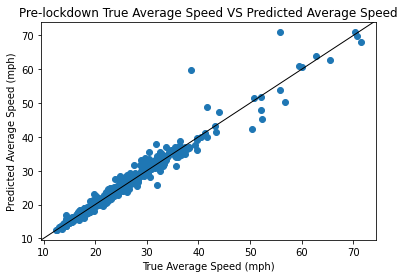

In [230]:
reg = LinearRegression() # set to trained linear model
reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)
training_accuracy = reg.score(X_train, y_train)
score = reg.score(X_val, y_val) # report r^2 score
# create the scatter plot below
plt.scatter(y_val, y_pred)
xpoints = ypoints = plt.xlim()
plt.xlabel("True Average Speed (mph)")
plt.ylabel("Predicted Average Speed (mph)")
plt.title("Pre-lockdown True Average Speed VS Predicted Average Speed");
plt.plot(xpoints, ypoints, color='k', lw=1, scalex=False, scaley=False);

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4aii2
points: 1
-->

In [231]:
score

0.9639232922122069

In [232]:
grader.check("q4aii2")

q4aii2 results: All test cases passed!

## 4.b. Understand failures on post-lockdown data

Your dataset is distributed spatially and temporally. As a result, the most intuitive spaces to visualize your model error or performance along is both spatially and temporally. In this step, we focus on understanding *where* your model fails.

### 4.b.i. Evaluate on post-lockdown data

1. Using your previously trained linear regression model `reg`, **evaluate on post-lockdown data**, meaning daily speed averages on March 14, 2020. Evaluate on all census tracts.
2. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

<!--
BEGIN QUESTION
name: q4bi1
points: 1
-->

In [233]:
time_series_x_pre = time_series.iloc[:, [8, 9, 10, 11, 12]] # get 'time series' dataframe for days 8, 9, 10, 11, 12
time_series_y_post = time_series.iloc[:, [13]] # get 'time series' dataframe for 13th

pre, post = remove_nans(time_series_x_pre.to_numpy(), time_series_y_post.to_numpy()[:, 0])
y_pred_4bi = reg.predict(pre)
score_pre_14th = reg.score(pre, post) # report r^2 score
score_pre_14th

0.9337122097376678

In [234]:
grader.check("q4bi1")

q4bi1 results: All test cases passed!

In [235]:
time_series_x_pre

day,9,10,11,12,13
MOVEMENT_ID,,,,,
9,14.845320,14.711534,13.739901,14.391436,13.955833
20,16.178105,15.295494,14.637109,14.282602,14.437358
21,15.616215,14.850471,13.790100,14.573349,15.177251
44,23.501387,22.739869,23.756560,24.989269,23.176275
78,16.253357,16.131290,15.773117,16.091415,16.208158
...,...,...,...,...,...
2691,19.038000,NaN,NaN,22.107000,NaN
2694,17.310272,16.998730,16.891788,17.008323,17.559142
2695,20.497077,20.401085,23.870537,20.215396,20.343131


In [236]:
time_series_y_post

day,14
MOVEMENT_ID,
9,15.878056
20,16.095385
21,15.172252
44,25.006452
78,15.128800
...,...
2691,17.917000
2694,17.714930
2695,20.321418


<!-- BEGIN QUESTION -->

Make scatter plot below.
<!--
BEGIN QUESTION
name: q4bi2
points: 1
manual: True
-->

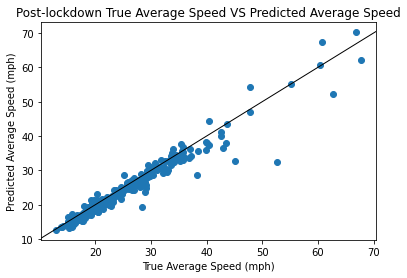

In [237]:
plt.scatter(post, y_pred_4bi)
xpoints = ypoints = plt.xlim()
plt.xlabel("True Average Speed (mph)")
plt.ylabel("Predicted Average Speed (mph)")
plt.title("Post-lockdown True Average Speed VS Predicted Average Speed");
plt.plot(xpoints, ypoints, color='k', lw=1, scalex=False, scaley=False);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 4.b.ii. Report model performance temporally

1. **Make a line plot** showing performance of the original model throughout all of March 2020.
2. **Report the lowest point on the line plot**, reflecting the lowest model performance.
2. **Why is model performance the worst on the 17th?** Why does it begin to worsen on march 15th? And continue to worsen? Use what you know about covid measures on those dates. You may find this webpage useful: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/
3. **Is the dip in performance on the 9th foreshadowed** by any of our EDA?
4. **How does the model miraculously recover on its own?**
5. **Make a scatter plot**, plotting predicted averages against ground truth averages *for model predictions on March 17th*. Note the perfect model would line up all points along the line $y=x$. When compared against previous plots of this nature, this plot looks substantially worse, with points straying far from $y=x$.

**Note:** Answer questions 2-5 in the Markdown cell below. Q1 and Q6 are answered in the two code cells below.

<!--
BEGIN QUESTION
name: q4bii1
points: 3
manual: True
-->



* Q2: The lowest point on the lint plot is March 17th.
* Q3: The model performance begins to worsen on March 15th, because all bars, nightclubs, wineries, and brewpubs are ordered to close, so the prediction just keeps getting worse from March 15th to 17th, where the model performance is the worst on the 17th. On the March 16th and 17th, SFMTA announces cable car service will be suspended and Uber & Lyft suspend shared ride options, which all significantly affect the traffic condition. Thus, this leads to the worst model performance on March 16th and March 17th.
* Q4: In our EDA, we do notice that the average speed in mph dropped significantly from March 8th to 9th. The high change in speed from March 4-8th makes the data for prediction on 9th inaccurate. Thus, the dip in the performance on the 9th is indeed foreshadowed by the volatile speed in mph in the previous day before March 9th.
* Q5: The model miraculously recovers on its own as the data with changed policies will be reflected in the model, and thus improves the model prediction as aligned with the changed policies.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate line plot.
<!--
BEGIN QUESTION
name: q4bii2
points: 1
manual: True
-->

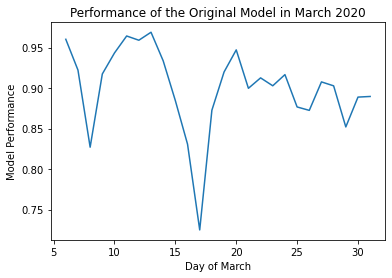

In [238]:
day = []
performance = []
for i in range(5,31):
    general_x_pre = time_series.iloc[:,i-5:i]
    gerneral_y_post = time_series.iloc[:,i]
    day.append(i+1)
    pre = general_x_pre.to_numpy()
    post = gerneral_y_post.to_numpy()
    pre,post = remove_nans(pre,post)
    pre_score = reg.score(pre,post)
    performance.append(pre_score)
plt.plot(day,performance)
plt.xlabel("Day of March")
plt.ylabel("Model Performance")
plt.title("Performance of the Original Model in March 2020");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate a scatter plot.
<!--
BEGIN QUESTION
name: q4bii3
points: 1
manual: True
-->

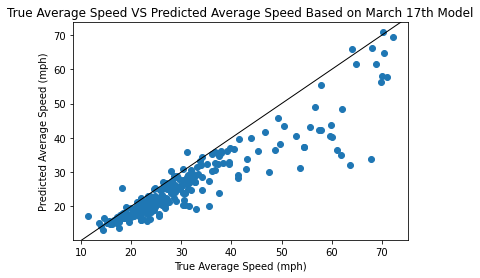

In [239]:
time_series_x_pre = time_series.iloc[:, [11,12, 13, 14, 15]] # get 'time series' dataframe for days 8, 9, 10, 11, 12
time_series_y_post = time_series.iloc[:, [16]] # get 'time series' dataframe for 13th

pre_4bii, post_4bii = remove_nans(time_series_x_pre.to_numpy(), time_series_y_post.to_numpy()[:, 0])
y_pred_4bii = reg.predict(pre_4bii)
score_pre_17th = reg.score(pre_4bii, post_4bii) # report r^2 score
score_pre_17th
plt.scatter(post_4bii, y_pred_4bii)
xpoints = ypoints = plt.xlim()
plt.xlabel("True Average Speed (mph)")
plt.ylabel("Predicted Average Speed (mph)")
plt.title("True Average Speed VS Predicted Average Speed Based on March 17th Model");
plt.plot(xpoints, ypoints, color='k', lw=1, scalex=False, scaley=False);

<!-- END QUESTION -->



## 4.c. "Fix" model on post-lockdown data

Per this survey https://pure.tue.nl/ws/files/3488790/740215.pdf, there are 4 categories of fixes for change points:
- Forgetting mechanisms
- Explicit change detection
- Ensemble techniques
- Context-aware approaches

In this part, we'll combine insights in model errors with previous EDA insights to produce a fix.

<!-- BEGIN QUESTION -->

### 4.c.i. Learn delta off of a moving bias

According to our previous work in EDA, the average speed shoots upwards sharply. As a result, our trick to learn delta the around the average and to naively assume that the average of day $t$ is the average for day $t+1$. We will do this in 4 steps:

1. **Create a dataset for your delta model**.
2. **Train your delta model** on pre-lockdown data.
3. **Evaluate your model on pre-lockdown data**, to ensure that the model has learned to a satisfactory degree, in the nominal case. Remember the naive model achieved 0.97 r^2 on pre-lockdown data.
4. **Evaluate your model on the 17th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score has improved by 10%+. Why is your delta model so effective for the 17th?
5. **Evaluate your model on the 14th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score is now complete garbage. Why is your delta so ineffective for the 14th?

**Hint**: As you build your datasets, always check to make sure you're using the right days! It's easy to have a one-off error that throws off your results.

Write your written questions in the next cell, then write the code in the following cells.

<!--
BEGIN QUESTION
name: q4ci1
points: 2
manual: True
-->

The model is effective for the 17th because the new model take the average of the previous days to increase the accuracy of the model. It is ineffective for the 14th because the new model separate the time series into pre and post on 14. We can not take the average for 14th since it is the first day of post lockdown. This makes the 14th becomes ineffective.

In [240]:
ave = speeds_daily[:13]

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4ci2
points: 1
-->

In [241]:
ave = speeds_daily[:13]
time_series_delta = time_series_pre.sub(ave) # subtract daily average from pre-lockdown 'time series' dataframe `time_series_pre`
time_series_delta

day,1,2,3,4,5,6,7,8,9,10,11,12,13
MOVEMENT_ID,,,,,,,,,,,,,
9,-7.436210,-7.929735,-7.957726,-7.706332,-7.673488,-8.288859,-7.342673,-7.838718,-8.163539,-7.950124,-9.037052,-8.687048,-9.364599
20,-6.215082,-6.863900,-6.363125,-6.511982,-6.693731,-6.873540,-5.762984,-5.960594,-6.830754,-7.366163,-8.139844,-8.795882,-8.883074
21,-8.491956,-9.147858,-8.044932,-7.879632,-7.907553,-8.464493,-8.893040,-9.407162,-7.392644,-7.811186,-8.986853,-8.505135,-8.143181
44,1.446417,1.167730,0.901289,0.342397,-0.110985,0.981564,0.024509,1.604391,0.492527,0.078211,0.979607,1.910786,-0.144157
78,-7.458664,-5.569360,-5.787301,-5.813345,-6.320619,-6.303126,-7.548693,-4.765377,-6.755502,-6.530367,-7.003837,-6.987069,-7.112274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,-3.385687,-4.313850,0.621691,NaN,-3.970859,NaN,NaN,-0.971484,NaN
2694,-5.823366,-5.598968,-5.295639,-5.485229,-5.482634,-5.448377,-5.423980,-5.992169,-5.698587,-5.662927,-5.885166,-6.070161,-5.761289
2695,-3.527067,-2.096006,-1.977287,-1.785869,0.371917,-2.850371,-3.627592,-4.578175,-2.511783,-2.260573,1.093583,-2.863087,-2.977301


In [242]:
grader.check("q4ci2")

q4ci2 results: All test cases passed!

In [243]:
X_delta_train, y_delta_train, X_delta_val, y_delta_val = time_series_to_dataset(time_series_delta,5,2)
reg_delta = LinearRegression() # set to trained linear model
reg_delta.fit(X_delta_train, y_delta_train)
y_pred_delta = reg_delta.predict(X_delta_val)
res_4ci3 = reg_delta.score(X_delta_val, y_delta_val) # learning delta as easy as learning original dataset!
res_4ci3

0.9645254590172871

In [244]:
grader.check("q4ci3")

q4ci3 results: All test cases passed!

In [245]:
time_series_x_pre_17 = time_series.iloc[:, [11, 12, 13, 14, 16]]  # get 'time series' dataframe for days 8, 9, 10, 11, 12
time_series_y_post_17 = time_series.iloc[:, [17]] # get 'time series' dataframe for 13th
pre_17, post_17 = remove_nans(time_series_x_pre_17.to_numpy(), time_series_y_post_17.to_numpy()[:, 0])
y_pred_17 = reg_delta.predict(pre_17)
res_4ci4 = reg_delta.score(pre_17, post_17)
res_4ci4 # report r^2 score

0.8598176829856077

In [246]:
grader.check("q4ci4")

q4ci4 results:
    q4ci4 - 1 result:
        Trying:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci4 0
        Failed example:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expected:
            True
        Got:
            False

In [247]:
time_series_x_pre_14 = time_series.iloc[:, [9, 10, 11, 12,13]] # get 'time series' dataframe for days 8, 9, 10, 11, 12
time_series_y_post_14 = time_series.iloc[:, [14]] # get 'time series' dataframe for 13th

pre_14, post_14 = remove_nans(time_series_x_pre_14.to_numpy(), time_series_y_post_14.to_numpy()[:, 0])
y_pred_14 = reg_delta.predict(pre_14) # report r^2 score
res_4ci5 = reg_delta.score(pre_14, post_14)
res_4ci5

0.8928928661782133

In [248]:
grader.check("q4ci5")

q4ci5 results:
    q4ci5 - 1 result:
        Trying:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci5 0
        Failed example:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Expected:
            True
        Got:
            False

### 4.c.ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?

Had we ignored the problem, would we have been okay? The temporal plot above showing performance over time suggests a partial recovery. **Evaluate the original, naive model on all post-lockdown data** to see. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4cii
points: 1
-->

In [249]:
ave = speeds_daily[13:]
time_series_post = time_series.iloc[:,13:]
time_series_post
time_series_post_diff = time_series_post.sub(ave)
time_series_post_diff

day,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
MOVEMENT_ID,,,,,,,,,,,,,,,,,,
9,-8.299408,-9.338214,-10.389922,-13.734386,-13.641223,-12.779786,-12.407735,-14.078221,-14.886413,-13.217318,-14.593316,-14.326131,-14.176914,-13.026410,-12.644404,-13.223493,-14.696735,-15.073404
20,-8.082079,-9.054164,-8.984059,-11.549345,-11.435672,-12.956209,-12.319996,-12.331840,-11.923115,-13.206947,-13.833915,-13.243846,-14.930962,-12.882609,-13.492034,-12.037986,-16.305162,-13.582838
21,-9.005212,-9.414061,-8.510261,NaN,NaN,-12.880008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,0.828988,-0.306110,0.422019,-2.026986,-1.744957,-2.403083,-0.872169,-3.932527,-6.384557,-4.886703,1.005324,NaN,-7.618157,-2.646682,-3.589791,-11.285278,-6.054702,-6.187231
78,-9.048664,-9.645762,-7.638639,-14.254335,-9.018352,NaN,NaN,NaN,NaN,NaN,-14.430710,NaN,NaN,-13.495251,NaN,NaN,-13.947111,-14.103253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,-6.260464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,-6.462535,-5.951842,-5.446096,-6.140698,-5.523367,-6.188752,-5.556760,-5.951042,-6.879915,-6.826698,-6.818314,-7.219769,-7.028956,-6.762366,-6.106592,-7.784706,-7.013222,-6.814296
2695,-3.856047,-2.568321,-1.331630,-3.223668,-1.797052,-4.124508,-1.625333,NaN,-1.547690,NaN,NaN,NaN,-6.740157,NaN,-10.781458,-4.600807,NaN,-10.911153


In [250]:
X_post_train, y_post_train, X_post_val, y_post_val = time_series_to_dataset(time_series_post,5,0)
# reg_delta = LinearRegression() # set to trained linear model
# reg_delta.fit(X_post_train, y_post_train)
# y_pred_post = reg.predict(X_post_val)
score_og_post = reg.score(X_post_train, y_post_train) # learning delta as easy as learning original dataset!
score_og_post

0.9014738674628208

In [251]:
grader.check("q4cii")

q4cii results: All test cases passed!

### 4.c.iii. Naively retrain model with post-lockdown data

Can we use the same tactics--that we used to train the original model on pre-lockdown data--to train on the post-lockdown data? **Retrain a linear model and evaluate on post-lockdown data only**. You should construct a new dataset using `time_series_to_dataset` using only time series from March 14 to March 31. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4ciii
points: 1
-->

In [252]:
X_post_train_2, y_post_train_2, X_post_val_2, y_post_val_2 = time_series_to_dataset(time_series_post,5,2)
reg_post_2 = LinearRegression() # set to trained linear model
reg_post_2.fit(X_post_train_2, y_post_train_2)
y_pred_post = reg_post_2.predict(X_post_val_2)
score_post = reg_post_2.score(X_post_val_2, y_post_val_2) # learning delta as easy as learning original dataset!
score_post

0.8993687576351703

In [253]:
time_series_post

day,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
MOVEMENT_ID,,,,,,,,,,,,,,,,,,
9,15.878056,16.360415,14.381899,15.177949,15.170129,16.722722,16.531998,15.984710,15.880078,17.019573,15.527393,15.925605,15.959744,17.317841,17.845053,17.839214,15.743376,15.797248
20,16.095385,16.644465,15.787762,17.362989,17.375680,16.546299,16.619737,17.731091,18.843376,17.029943,16.286795,17.007889,15.205696,17.461643,16.997424,19.024721,14.134949,17.287814
21,15.172252,16.284568,16.261560,NaN,NaN,16.622500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,25.006452,25.392519,25.193840,26.885349,27.066394,27.099425,28.067563,26.130405,24.381933,25.350188,31.126033,NaN,22.518500,27.697570,26.899667,19.777429,24.385409,24.683422
78,15.128800,16.052867,17.133182,14.658000,19.793000,NaN,NaN,NaN,NaN,NaN,15.690000,NaN,NaN,16.849000,NaN,NaN,16.493000,16.767400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,17.917000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17.714930,19.746787,19.325724,22.771637,23.287984,23.313756,23.382973,24.111889,23.886576,23.410192,23.302396,23.031966,23.107702,23.581885,24.382866,23.278001,23.426889,24.056357
2695,20.321418,23.130308,23.440190,25.688667,27.014300,25.378000,27.314400,NaN,29.218800,NaN,NaN,NaN,23.396500,NaN,19.708000,26.461900,NaN,19.959500


In [254]:
grader.check("q4ciii")

q4ciii results: All test cases passed!

### 4.c.iv. What if you just ignore the change point?

Turns out, this is no good. Even acknowledging the change point and training *either* before *or* after is better. Being ignorant and training on *both* is the worst option, producing a lower r^2.

<!--
BEGIN QUESTION
name: q4civ
points: 1
-->

In [255]:
X_all_train, y_all_train, X_all_val, y_all_val = time_series_to_dataset(time_series,5,5)
reg_all = LinearRegression() # set to trained linear model
reg_all.fit(X_all_train, y_all_train)
y_pred_post = reg_all.predict(X_all_val)  # learning delta as easy as learning original dataset!
res_4civ = reg_all.score(X_all_val, y_all_val)
res_4civ

0.8843433608623493

In [256]:
grader.check("q4civ")

q4civ results: All test cases passed!

# Step 5 - Open-Ended Modeling: Predicting travel time post-lockdown

*This* is the real deal and ultimately what Uber cares about. Traffic speeds is a proxy task, but the bottom line and moneymaking machine relies on this travel time estimation. Focus on designing experiments instead of focusing on experimental, quantitative results. Your experiments are successful if they inform a decision, even despite a lower-performing model.

## Question 5a

Train a baseline model of your choice using any supervised learning approach we have studied; you are not limited to a linear model.


**Example**

Given the data for this question, you could build a model to predict travel time from Cheesecake Factory to UC Berkeley.

In [257]:
time_series

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
MOVEMENT_ID,,,,,,,,,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,...,15.880078,17.019573,15.527393,15.925605,15.959744,17.317841,17.845053,17.839214,15.743376,15.797248
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,...,18.843376,17.029943,16.286795,17.007889,15.205696,17.461643,16.997424,19.024721,14.134949,17.287814
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,...,24.381933,25.350188,31.126033,NaN,22.518500,27.697570,26.899667,19.777429,24.385409,24.683422
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,...,NaN,NaN,15.690000,NaN,NaN,16.849000,NaN,NaN,16.493000,16.767400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,...,23.886576,23.410192,23.302396,23.031966,23.107702,23.581885,24.382866,23.278001,23.426889,24.056357
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,...,29.218800,NaN,NaN,NaN,23.396500,NaN,19.708000,26.461900,NaN,19.959500


### To build and train this model of delta data from the previous ideas, we normalize the time_series dataset by subtract the average speed across all days as a baseline. As the linear regression model has self-contained bias term, this normalization would not help to improve the model accuracy, so this could serve as a solid baseline. Besides, we fill NANs with mean values in speed_average_baseline.

In [258]:
ave_all_days = speeds_daily.copy()
time_series_delta_baseline = time_series.sub(ave_all_days) # subtract daily average from all days 'time series' dataframe
X_delta_train_baseline, y_delta_train_baseline, X_delta_val_baseline, y_delta_val_baseline = time_series_to_dataset(time_series_delta_baseline,5,2)
reg_delta_baseline = LinearRegression() # set to trained linear model
reg_delta_baseline.fit(X_delta_train_baseline, y_delta_train_baseline)
y_pred_delta_baseline = reg_delta_baseline.predict(X_delta_val_baseline)

reg_delta_baseline.score(X_delta_val_baseline, y_delta_val_baseline) # learning delta as easy as learning original dataset!

0.8972160250209321

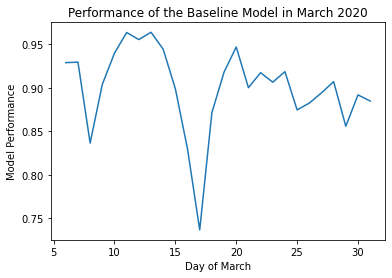

In [259]:
day_baseline = []
performance_baseline = []
for i in range(5,31):
    general_x_pre = time_series.iloc[:,i-5:i]
    gerneral_y_post = time_series.iloc[:,i]
    day_baseline.append(i+1)
    pre = general_x_pre.to_numpy()
    post = gerneral_y_post.to_numpy()
    pre,post = remove_nans(pre,post)
    pre_score = reg_delta_baseline.score(pre,post)
    performance_baseline.append(pre_score)
plt.plot(day_baseline,performance_baseline)
plt.xlabel("Day of March")
plt.ylabel("Model Performance")
plt.title("Performance of the Baseline Model in March 2020");

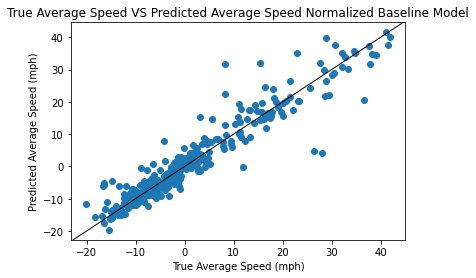

In [260]:
plt.xlabel("True Average Speed (mph)")
plt.ylabel("Predicted Average Speed (mph)")
plt.title("True Average Speed VS Predicted Average Speed Normalized Baseline Model")
plt.scatter(y_delta_val_baseline, y_pred_delta_baseline)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='k', lw=1, scalex=False, scaley=False);

## Question 5b

Improve on your baseline model. Specify the model you designed and its input features. Justify why you chose these features and their relevance to your model's predictions.

**Example**

Here are potential questions to consider for this part: How does the other variant of your travel times dataset, aggregated across time but reported for all routes, useful?  What additional data from the Uber Movement website can you export to better your model?

In [261]:
test_weekend = lambda x: x % 7 <= 1
test_weekday = lambda x: x % 7 > 2
speed_average_weekend = time_series[1]
speed_average_weekday = time_series[2]
for i in range(3, 32):
    if test_weekend(i):
        speed_average_weekend = speed_average_weekend + time_series[i]
    else:
        speed_average_weekday = speed_average_weekday + time_series[i]
speed_average_weekend = speed_average_weekend / 9
speed_average_weekday = speed_average_weekday / 22

delta_time_series_day_week = time_series.copy()
for i in range(1, 32):
    if test_weekend(i):
        delta_time_series_day_week[i] = delta_time_series_day_week[i] - speed_average_weekend
    else:
        delta_time_series_day_week[i] = delta_time_series_day_week[i] - speed_average_weekday

X_delta_train_day_week, y_delta_train_day_week, X_delta_val_day_week, y_delta_val_day_week = time_series_to_dataset(time_series_post_diff,5,2)
reg_delta_day_week = LinearRegression() # set to trained linear model
reg_delta_day_week.fit(X_delta_train_day_week, y_delta_train_day_week)
y_pred_delta_day_week = reg_delta_day_week.predict(X_delta_val_day_week)
reg_delta_day_week.score(X_delta_val_day_week, y_delta_val_day_week)

0.9057021269977523

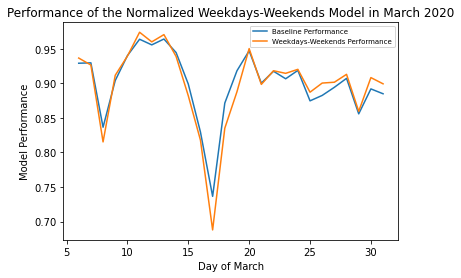

In [262]:
day_week = []
performance_week = []
for i in range(5,31):
    general_x_pre = time_series.iloc[:,i-5:i]
    gerneral_y_post = time_series.iloc[:,i]
    day_week.append(i+1)
    pre = general_x_pre.to_numpy()
    post = gerneral_y_post.to_numpy()
    pre,post = remove_nans(pre,post)
    pre_score = reg_delta_day_week.score(pre,post)
    performance_week.append(pre_score)
plt.plot(day_baseline,performance_baseline, label = "Baseline Performance")
plt.plot(day_week,performance_week, label = "Weekdays-Weekends Performance")
plt.xlabel("Day of March")
plt.ylabel("Model Performance")
plt.legend(prop={"size":7})
plt.title("Performance of the Normalized Weekdays-Weekends Model in March 2020");

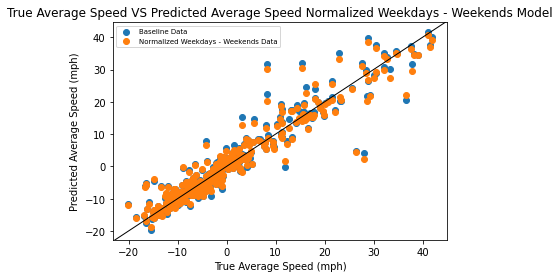

In [263]:
plt.scatter(y_delta_val_baseline, y_pred_delta_baseline,label= "Baseline Data")
plt.scatter(y_delta_val_day_week, y_pred_delta_day_week,label= "Normalized Weekdays - Weekends Data")
plt.xlabel("True Average Speed (mph)")
plt.ylabel("Predicted Average Speed (mph)")
plt.legend(prop={"size":7})
plt.title("True Average Speed VS Predicted Average Speed Normalized Weekdays - Weekends Model")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='k', lw=1, scalex=False, scaley=False);

## Question 5c

Explore other modeling aspects and/or temporal information. You are free to relate this to your hypothesis or not. Please expand into multiple parts that logically separate and break down your modeling work!

**Example**

For example, explore change across time, before and after the lockdown: (a) train and evaluate on *pre*-lockdown traffic travel times for that route; and (b) evaluate your model on *post*-lockdown traffic patterns.
How would you correct your model for a more accurate post-lockdown traffic predictor? *The above is just a suggestion. You may pick any topic you find interesting.*

In [264]:
test_weekend = lambda x: x % 7 <= 1
test_weekday = lambda x: x % 7 > 2
speed_average_weekend_pre = time_series[1]
speed_average_weekend_post = time_series[14]
speed_average_weekday_pre = time_series[2]
speed_average_weekday_post = time_series[16]
for i in range(1, 32):
    if test_weekend(i) and i <= 13:
        speed_average_weekend_pre = speed_average_weekend_pre + time_series[i]
    elif test_weekday(i) and i <= 13:
        speed_average_weekday_pre = speed_average_weekday_pre + time_series[i]
    elif test_weekend(i) and i > 13:
        speed_average_weekend_post = speed_average_weekend_post + time_series[i]
    else:
        speed_average_weekday_post = speed_average_weekday_post + time_series[i]
speed_average_weekend_pre = speed_average_weekend_pre / 3
speed_average_weekend_pre.fillna(value=np.mean(ave_all_days), inplace=True)
speed_average_weekend_post = speed_average_weekend_post / 6
speed_average_weekend_post.fillna(value=np.mean(ave_all_days), inplace=True)
speed_average_weekday_pre = speed_average_weekday_pre / 10
speed_average_weekday_pre.fillna(value=np.mean(ave_all_days), inplace=True)
speed_average_weekday_post = speed_average_weekday_post / 21
speed_average_weekday_post.fillna(value=np.mean(ave_all_days), inplace=True)

for speed_average in [speed_average_weekend_pre, speed_average_weekend_post, speed_average_weekday_pre, speed_average_weekday_post]:
    lower, upper = np.mean(speed_average) - 2 * np.std(speed_average), np.mean(speed_average) + 2 * np.std(speed_average)
    for idx in speed_average.index:
        if speed_average[idx] < lower or speed_average[idx] > upper:
            speed_average[idx] = ave_all_days

delta_time_series_day_week_prepost = time_series.copy()
for i in range(1, 32):
    if test_weekend(i) and i <= 13:
        delta_time_series_day_week_prepost[i] = delta_time_series_day_week_prepost[i] - speed_average_weekend_pre
    elif test_weekday(i) and i <= 13:
        delta_time_series_day_week_prepost[i] = delta_time_series_day_week_prepost[i] - speed_average_weekday_pre
    elif test_weekend(i) and i > 13:
        delta_time_series_day_week_prepost[i] = delta_time_series_day_week_prepost[i] - speed_average_weekend_post
    else:
        delta_time_series_day_week_prepost[i] = delta_time_series_day_week_prepost[i] - speed_average_weekday_post

X_delta_train_day_week_prepost, y_delta_train_day_week_prepost, X_delta_val_day_week_prepost, y_delta_val_day_week_prepost = time_series_to_dataset(time_series_post_diff,5,2)
reg_delta_day_week_prepost = LinearRegression() # set to trained linear model
reg_delta_day_week_prepost.fit(X_delta_train_day_week_prepost, y_delta_train_day_week_prepost)
y_pred_delta_day_week_prepost = reg_delta_day_week_prepost.predict(X_delta_val_day_week_prepost)
day_week_pre_post_score = reg_delta_day_week_prepost.score(X_delta_val_day_week_prepost, y_delta_val_day_week_prepost)

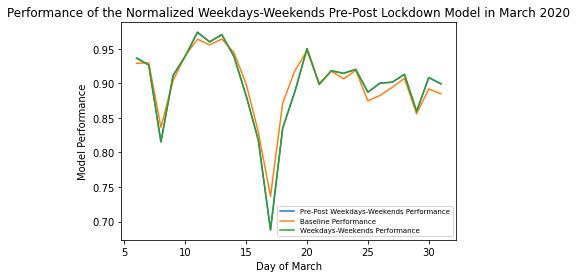

In [265]:
day_prepost = []
performance_prepost = []
for i in range(5,31):
    general_x_pre = time_series.iloc[:,i-5:i]
    gerneral_y_post = time_series.iloc[:,i]
    day_prepost.append(i+1)
    pre = general_x_pre.to_numpy()
    post = gerneral_y_post.to_numpy()
    pre,post = remove_nans(pre,post)
    pre_score = reg_delta_day_week_prepost.score(pre,post)
    performance_prepost.append(pre_score)
plt.plot(day_prepost,performance_prepost, label = "Pre-Post Weekdays-Weekends Performance")
plt.plot(day_baseline,performance_baseline, label = "Baseline Performance")
plt.plot(day_week,performance_week, label = "Weekdays-Weekends Performance")
plt.xlabel("Day of March")
plt.ylabel("Model Performance")
plt.legend(prop={"size":7})
plt.title("Performance of the Normalized Weekdays-Weekends Pre-Post Lockdown Model in March 2020");

0.9057021269977523


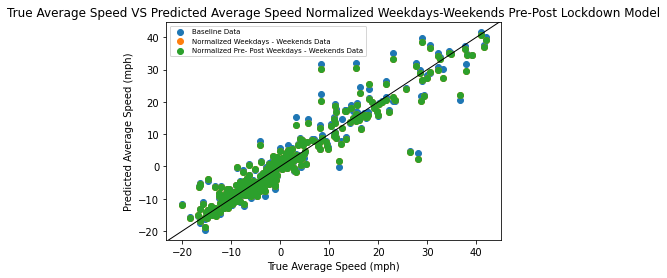

In [266]:
plt.scatter(y_delta_val_baseline, y_pred_delta_baseline,label= "Baseline Data")
plt.scatter(y_delta_val_day_week, y_pred_delta_day_week,label= "Normalized Weekdays - Weekends Data")
plt.scatter(y_delta_val_day_week_prepost, y_pred_delta_day_week_prepost,label= "Normalized Pre- Post Weekdays - Weekends Data" )
plt.xlabel("True Average Speed (mph)")
plt.ylabel("Predicted Average Speed (mph)")
plt.title("True Average Speed VS Predicted Average Speed Normalized Weekdays-Weekends Pre-Post Lockdown Model")
plt.legend(prop={"size":7})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='k', lw=1, scalex=False, scaley=False);
print(day_week_pre_post_score)

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [270]:
grader.check_all()

q1a results: All test cases passed!

q1bi results: All test cases passed!

q1bii results: All test cases passed!

q1biii results: All test cases passed!

q1biv results: All test cases passed!

q1bv3 results: All test cases passed!

q1ci results: All test cases passed!

q1cii results: All test cases passed!

q1ciii results: All test cases passed!

q1civ3 results: All test cases passed!

q2ai2 results: All test cases passed!

q2ai3 results: All test cases passed!

q2ai4 results: All test cases passed!

q2aii2 results: All test cases passed!

q2aiii results: All test cases passed!

q2aiv3 results: All test cases passed!

q2av2 results: All test cases passed!

q4ai1 results: All test cases passed!

q4ai2 results: All test cases passed!

q4ai3 results: All test cases passed!

q4aii2 results: All test cases passed!

q4bi1 results: All test cases passed!

q4ci2 results: All test cases passed!

q4ci3 results: All test cases passed!

q4ci4 results:
    q4ci4 - 1 result:
        Trying:
        

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [271]:
# Save your notebook first, then run this cell to export your submission.
grader.export()